# Introduction to Natural Language Processing: Summative Code

**Candidate Number: 1047904**

**20 April, 2021**

# Libraries

In [99]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cosine
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
import math
import os

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from textwrap import wrap
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns 
%matplotlib inline

import fasttext
from collections import Counter, defaultdict
import re
import itertools

from nltk import tokenize
from nltk.util import bigrams
from nltk import ngrams
from string import punctuation
from sklearn.feature_extraction import stop_words

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

# Functions

## Functions - Exploratory Analysis

**General Utility Functions**

In [71]:
def create_label_dicts(labels):
    """create dictionaries from list of labels"""
    label2id = {k:v for v,k in enumerate(sorted(labels,reverse=False))}
    id2label = {v:k for k,v in label2id.items()}
    
    print(f"label2id: {label2id}")
    print(f"id2label: {id2label}")
    
    return label2id,id2label

def pub_per_year(labels,df,col):
    """get counts of publications across category tags and years"""
    
    table = defaultdict(list)
    for label in labels:
        pub_per_year = df.loc[df[col] == label].groupby("year").size()
    
        for key,value in zip(pub_per_year.index,pub_per_year.values):
            table[key].append(value)
    
    table_df = pd.DataFrame.from_dict(table,orient="index", columns=labels)
    
    return table_df

def clean(text):
    """clean abstract text - strip, split, lowercase and conditional removal of punctuation"""
    return [w.strip(punctuation).lower() for w in text.strip().split() if w.strip(punctuation) != '']

def fasttext_emb_dict(word_freq_dict, emb, approx_oov=False):
    """Create dictionnary with fasttext embeddings for abstract word space 
    
    Parameters: 
    
    arg1 (Counter): Counter dict containing word freq counts for all words irrespective of class membership
    arg2 (bin): fasttext word vector collection in raw format 
    arg3 (Bool): Whether or not approximiations will for oov words will be provisioned by fasttext (default )
    
    returns:
    
    embedding dict 
    oov dict
    
    """
    
    if approx_oov == True:
        
        return {word[0]: emb.get_word_vector(word[0]) for word, _ in word_freq_dict.most_common()}
    
    if approx_oov == False:
    
        oov_dict = Counter({word[0]:count for word, count in word_freq_dict.most_common() if emb.get_word_id(word[0]) == -1})
        
        print(f"most freq 10 OOV words: {oov_dict.most_common(10)}")
        print(f"# of unique OOV words: {len(oov_dict.keys())} / {round((len(oov_dict.keys())/ len(word_freq_dict.keys())),2)*100}%")
        print(f"# OOV word frequencies: {sum(oov_dict.values())} / {round((sum(oov_dict.values())/ sum(word_freq_dict.values())),2)*100}%")
        
        return {word[0]: emb.get_word_vector(word[0]) for word, _ in word_freq_dict.most_common() if emb.get_word_id(word[0]) != -1}, oov_dict    


def sample_df(df,year,s_size,verbose = True):
    """take stratified sample per category and year beyond temporal cut-off (i.e. >= certain year)"""
    df_temp = df.loc[df.year >= year]
    
    df_temp = df.groupby(["year","cat"],as_index=False).apply(lambda x: x.sample(min(len(x),s_size),random_state=123)).reset_index(drop=True)
    
    if verbose:
        
        display(pub_per_year(list(df_temp.cat.unique()),df_temp,"cat"))
    
    return df_temp

def abstract2vec(abstract, vectors):
    """average word embeddings into abstract vector"""
    return np.mean([vectors[w] for w in abstract if w in vectors], axis=0)

**Functions used in actual analysis**

In [82]:
def jaccard_sim(vocab_1, vocab_2,rounding= False):
    """calculate Jaccard similarity """
    
    intersection = len(set(vocab_1).intersection(set(vocab_2)))
    union = len(set(vocab_1).union(set(vocab_2)))
    
    if rounding == False:  
        return intersection / union
    else:
        return round((intersection / union),3)
        
def tabulate_jaccard_sim(label2id,ngram_dict,rounding=False):
    """returns cross-tabulation of pairwise jaccard similarities"""
    # Initialize table as dictionary
    table = dict()
    
    for key_i in label2id.keys():
        
        table[key_i] = list()
        
        for key_j in label2id.keys():
            
            # Calculate Jaccard similarity
            table[key_i].append(jaccard_sim(ngram_dict[key_i], ngram_dict[key_j],rounding = rounding))
    
    return pd.DataFrame.from_dict(table, orient='index',columns =label2id.keys())

def calc_sim_measures (cat1,cat2,vocab_dict):
    """calculate entropy, cross entropy & KL-divergence"""
    cat_dict = defaultdict(list)
    
    common_vocab = set(vocab_dict[cat1]).intersection(vocab_dict[cat2])
    #print(len(common_vocab ))
    
    cat1_dict = {k:vocab_dict[cat1][k] for k in common_vocab}
    cat2_dict = {k:vocab_dict[cat2][k] for k in common_vocab}
    
    cat1_total = sum(cat1_dict.values())
    #print(cat1_total)
    cat2_total = sum(cat2_dict.values())
    #print(cat2_total)
    
    cat_dict[cat1] = [v/cat1_total for _,v in cat1_dict.items()]
    cat_dict[cat2] = [v/cat2_total for _,v in cat2_dict.items()]
    
    # Calculate entropy 
    e = -np.sum(cat_dict[cat1] * np.log(cat_dict[cat1]))
    # Calculate cross-entropy (i.e. how well are we able to approximate true dis ci with random dis)
    ce = -np.sum(cat_dict[cat1] * np.log(cat_dict[cat2]))
    # KL divergence 
    kl = ce-e
    
    return [round(i,2) for i in (e,ce,kl)]

def mi(w, n_posts,docs_per_label,label1,label2):
    """calculate mututal information"""
    
    n = np.array([[n_posts[label1][w], docs_per_label[label1] - n_posts[label1][w]], [n_posts[label2][w], docs_per_label[label2] - n_posts[label2][w]]])

    n = n / n.sum()
 
    return np.sum([n[i, j] * np.log2(n[i, j] / (n[i, :].sum() * n[:, j].sum())) for j in range(2) for i in range(2)])

def tabulate_mi(mi_output,size=10):
    """tabulate mutual information irrespective of class label"""
    temp_dict = defaultdict(list)
    
    for v,w in mi_output[:size]:
        temp_dict["word"].append(w)
        temp_dict["mi"].append(v)
    
    return pd.DataFrame.from_dict(temp_dict) 

def tabulate_mi_per_label(label2id,label1,label2,mi_output,n_posts,size=10):
    """tabulate mutual information by class label"""
    temp_dict = defaultdict(list)
    
    temp_dict[label1] = [w for mi_output, w in mi_output if n_posts[label2id[label1]][w] > n_posts[label2id[label2]][w]][:size]
    temp_dict[label2] = [w for mi_output, w in mi_output if n_posts[label2id[label2]][w] > n_posts[label2id[label1]][w]][:size]
    
    return pd.DataFrame.from_dict(temp_dict)

def get_ngram_dict(abstracts,labels,grams = 1, remove_stopwords = True,verbose = True,n_most_common = 30, per_class = True):
    """Get Frequency Counts per word """

    if per_class:
    
        vocab_dict = defaultdict(Counter)
        n_posts = defaultdict(Counter)
    
        if remove_stopwords:
            for words,label in zip(abstracts,labels):
                vocab_dict[label].update(ngrams([word for word in words if word not in stop_words.ENGLISH_STOP_WORDS ],grams))
                n_posts[label].update(set(ngrams([word for word in words if word not in stop_words.ENGLISH_STOP_WORDS ],grams)))
                                 
        else:
            for words,label in zip(abstracts,labels):
                vocab_dict[label].update(ngrams([word for word in words],grams))
                n_posts[label].update(set(ngrams([word for word in words],grams)))
        
        if verbose:
            
            for label in labels.unique():
                
                print("=="*10 + f"{label} - Top 30" + "=="*10)
                print(vocab_dict[label].most_common(n_most_common))
        
        return vocab_dict,n_posts
        
    else: 
        
        vocab_dict = Counter()
        n_posts = defaultdict(Counter)
        
        if remove_stopwords:
            for words in abstracts:
                vocab_dict.update(ngrams([word for word in words if word not in stop_words.ENGLISH_STOP_WORDS ],grams))
                                 
        else:
            for words in abstracts:
                vocab_dict.update(ngrams([word for word in words],grams))
        
        return vocab_dict
    
def tabulate_freq_words(label,freq_dict,most_freq=10,count=False,filter_label = True):
    """return most frequent words in descending order"""
    temp_dict = defaultdict(list)
    
    #Return results within subject across years (e.g. stat.ML_2017,...,stat.ML_2020)
    if filter_label:
    
        for k in sorted([k for k in freq_dict.keys() if label in k]):
            for l,_ in freq_dict[k].most_common(most_freq):
                
                if count:
                    temp_dict[k].append((l,_))
                else:
                    temp_dict[k].append(l)       
    #Return results between subject across years (i.e. stat.ML vs. cs.AI)
    else:
        
        for k in sorted([k for k in freq_dict.keys()]):
            for l,_ in freq_dict[k].most_common(most_freq):
                
                if count:
                    temp_dict[k].append((l,_))
                else:
                    temp_dict[k].append(l)  
                
    return pd.DataFrame.from_dict(temp_dict)

def cosine_sim(v_i, v_j):
    """calculate cosine similarity between 2 embeddings"""
    return 1 - cosine(v_i, v_j)

def nn_homogen(df,granularity_label,granularity_comp,n_nb=5):
    """assess avg share of kindred nearest neighbours per class label"""
    
    lookup_dict = {row["id"]:row[granularity_label] for _,row in df.iterrows()}
    
    cos_df = pd.DataFrame(columns = ["label","neighbor_id","cat1","cat2","cos_similarity"])
    
    counter = 0
    for i in itertools.permutations(train_sub.id,2):
        cos_df.loc[counter,:] = [i[0],
                                 i[1],
                                 train_sub.loc[train_sub["id"]==i[0],granularity_comp].item(),
                                 train_sub.loc[train_sub["id"]==i[1],granularity_comp].item(),
                                 cosine_sim(train_sub.loc[train_sub["id"]==i[0],"abstract_clean_vec"].item(),train_sub.loc[train_sub["id"]==i[1],"abstract_clean_vec"].item())]
        
        counter +=1
    
    cos_gr = cos_df.groupby("label",as_index=False).apply(lambda x: x.sort_values("cos_similarity",ascending=False).iloc[:n_nb]).reset_index(drop=True)
    
    cos_gr["match"]= cos_gr.apply(lambda x: 1 if x.loc["cat1"]==x.loc["cat2"] else 0,axis=1) 
    
    res_df = pd.DataFrame(cos_gr.groupby("label")["match"].apply(lambda x: sum(x)/len(x))).reset_index(drop=False)

    res_df.label = res_df.label.map(lambda x: lookup_dict[x])
    
    return pd.DataFrame(res_df.groupby("label")["match"].mean()).reset_index()

## Functions - Classification Experiments

In [42]:
############# PRE PROCESSING FUNCTIONS ############# 

def abstract_clean2n_gram (abstract, grams=2):
    """Convert abstract into list of n-grams"""
    if grams == 1:
        return abstract
    
    else:
        return [gram for gram in ngrams(abstract,grams)]

def rem_stopwords(abstract):
    """Remove stopwords from each abstract"""
    abstract = [w for w in abstract if w not in stop_words.ENGLISH_STOP_WORDS]
    return abstract

def count_words(abstracts,remove_stopwords=True):
    """Create lookup dictionaries for sparse vec creation"""
    if remove_stopwords:
        
        word_counter = Counter([w for abstract in abstracts for w in abstract if w not in stop_words.ENGLISH_STOP_WORDS])
     
    else:
        word_counter = Counter([w for abstract in abstracts for w in abstract]) 
        
    w2id = {w: i + 2 for i, w in enumerate(w for w, c in word_counter.most_common())}
    # Create dictionary for reverse word look-up
    id2w = {i: w for w, i in w2id.items()}
        
    return w2id,id2w,word_counter

def encode_abstract(sent, w2id):
    """convert tokenized abstract into list of integers based on lookup dict"""
    return [w2id[w] if w in w2id else 1 for w in sent]

def abstract_enc_redux(abstract_enc,size=200):
    """Reduce integer representation to retained featured as per pruning scheme """
    return list(filter(lambda x: x <= size,abstract_enc)) 

def sent2sparse(abstract_enc,id2w):
    """Turn integer vector into sparse vector"""
    counter = Counter(abstract_enc)
    return [counter[w] for w in id2w]

In [43]:
############# GATING FUNCTIONS ############# 

def chunks(lst, n):
    """Yield successive n-sized chunks from list"""
    
    for i in range(0, len(lst),n):
        yield lst[i:i + n]

    
        
def partition_abstract (abstract_clean, perc = 0.2, section = 0):
    """Partition abstract into chunks and retrieve specific sections (i.e. simulation of sliding window)"""
    abs_length = math.floor(len(abstract_clean) * perc)
        
    if abs_length == len(abstract_clean) * perc:
        
        return list(chunks(abstract_clean,abs_length))[section]
    
    if abs_length != len(abstract_clean) * perc:
        
        try: 
        
            if len(list(chunks(abstract_clean,abs_length))[section+1]) < abs_length:
                
                return list(chunks(abstract_clean,abs_length))[section] + list(chunks(abstract_clean,abs_length))[section+1]
            
            else: 
                return list(chunks(abstract_clean,abs_length))[section]
       
        except IndexError:
            
            return list(chunks(abstract_clean,abs_length))[section]

def shorten_abstract (abstract, perc=0.1):
    "Only consider front x % of an abstract"
    abs_short = abstract[:int(len(abstract)*perc)]
    return abs_short

In [44]:
#################### FUTURE PRUNING - MI ####################

def enumerate2(xs, start=0, step=1):
    for x in xs:
        yield (start, x)
        start += step

def get_mi_per_label_lookup (df,label2id,label1,label2,gram=1):
    
    vocab,n_posts = get_ngram_dict(df.abstract_clean,df.cat_label, grams = gram, remove_stopwords = True,verbose = False,n_most_common = 30)
    
    docs_per_label = dict(df.cat_label.value_counts())
    
    mi_output = sorted([(mi(w, n_posts,docs_per_label,label2id[label1],label2id[label2]), w)
                     for w in set(vocab[label2id[label1]]).intersection(set(vocab[label2id[label2]]))],reverse=True)
    
    temp_dict = defaultdict(list)
    
    if gram ==1:
    
        list_1 = [w[0] for mi_output, w in mi_output if n_posts[label2id[label1]][w] >= n_posts[label2id[label2]][w]]
        list_2 = [w[0] for mi_output, w in mi_output if n_posts[label2id[label2]][w] > n_posts[label2id[label1]][w]]
        
        dict_1 = {w:i for (i,w) in list(enumerate2(list_1, start=2, step=2))}
        dict_2 = {w:i for (i,w) in list(enumerate2(list_2, start=3, step=2))}
    
    else:
        
        list_1 = [w for mi_output, w in mi_output if n_posts[label2id[label1]][w] >= n_posts[label2id[label2]][w]]
        list_2 = [w for mi_output, w in mi_output if n_posts[label2id[label2]][w] > n_posts[label2id[label1]][w]]
        
        dict_1 = {w:i for (i,w) in list(enumerate2(list_1, start=2, step=2))}
        dict_2 = {w:i for (i,w) in list(enumerate2(list_2, start=3, step=2))}
    
    w2id = {}
    
    for d in [dict_1,dict_2]:
        for k,v in d.items():
            w2id[k]=v
                
    id2w = {i:w for w,i in w2id.items()}
    
    return w2id, id2w,vocab

def oov_rem (abstract,vocab):
    """strip away abstract text that is not in Mutual Info intersection between classes"""
    return [w for w in abstract if w in vocab]

def vocab_redux (absract_clean_ngram,common_vocab):
    return [i for i in absract_clean_ngram if i in list(common_vocab)]

In [45]:
# Define function for classifier training and evaluation
def train_classifier(classifier, train_x, train_y, dev_x, dev_y, test_x, test_y, device):
    
    # Define training objective
    criterion = nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = optim.Adam(classifier.parameters(), lr=0.01)
    
    #Define empty helper objects
    
    val_acc = list()
    
    # Move model and data to CUDA
    classifier = classifier.to(device)
    #LEARNING very lean why to adminster Device encodings
    [train_x, train_y, dev_x, dev_y, test_x, test_y] = [data.to(device) for data in [train_x, train_y, dev_x, dev_y, test_x, test_y]]
    
    # Train model
    for epoch in range(1, 21):
        
        # Perform forward pass
        classifier.train()
        optimizer.zero_grad()
        output = classifier(train_x)
        loss = criterion(output, train_y)
        
        # Perform backpropagation
        loss.backward()
        
        # Update model weights
        optimizer.step()
        
        # Evaluate model every fifth epoch
        if epoch % 5 == 0:

            classifier.eval()

            with torch.no_grad():
                    
                    # Perform forward pass
                    output =  classifier(dev_x)
                    
                    # Make prediction
                    #LEARNING: returns column indices per row due to dim=1 (per row, i.e. across cols), keep dim adds
                    #back col dimension to output tensor
                    max_output = output.argmax(dim=1, keepdim=True)
                    
                    # Compute accuracy
                    #LEARNING: torch.squeeze(1) removes first dimension
                    acc = max_output.squeeze(1).eq(dev_y).sum() / torch.FloatTensor([dev_y.shape[0]])
                    
                    val_acc.append(acc.data.item())
                                                                                    
                    print('Accuracy on dev data after {:02d} epochs: {:.4f}'.format(epoch, acc.data.item()))
    
    # Test model
    classifier.eval()
        
    with torch.no_grad():
        
        # Perform forward pass
        output =  classifier(test_x)
        
        # Make prediction
        max_output = output.argmax(dim=1, keepdim=True)
        
        # Compute accuracy
        #LEARNING: extracting the shape just gives skalar output which is not of type tensor 
        acc = max_output.squeeze(1).eq(test_y).sum() / torch.FloatTensor([test_y.shape[0]])
        
        print('Accuracy on test data: {:.4f}'.format(acc.data.item()))

    # Return labels and predictions
    return acc.data.item(),val_acc,[l.item() for l in test_y], [p.item() for p in max_output]

In [46]:
# Define logistic regression classifier class
class LRClassifier(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        
        super(LRClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Data Loading, Cleaning & Sampling

In [12]:
#Load Data (data was previously one-time annotated and saved to ease run-times during kernel restarts)
df = pd.read_csv('Data/arxiv_mod.csv',dtype={'id': str})

#Create Class labels 
df['update_date']= pd.to_datetime(df['update_date'])
df =df.rename(columns = {"update_date":"date"})
df["year"] = df.date.dt.year
df["cat_year"] = df["cat"] + "_" + df["year"].astype(str)

#subset relevant columns and filter out years before 2017
df_sub = df.loc[(df.cat != "neither") & (df.year >= 2017),["id","abstract","cat","cat_year","year"]].reset_index(drop=True)

#clean abstracts: tokenize, lowercase, remove blank spaces & punctuation
df_sub["abstract_clean"] = df_sub.abstract.map(lambda x: clean(x))

#stratify-subsample data (undersampling of majority class "stat.ML")
print("=="*4 + f"Entire dataset" + "=="*4)
df_sampled = sample_df(df_sub,2017,2000,verbose =True)

# Split data into training, development, and test sets
train, dev_test = train_test_split(df_sampled, test_size=0.2, stratify=df_sampled['cat_year'], random_state=0)
dev, test = train_test_split(dev_test, test_size=0.5, stratify=dev_test['cat_year'], random_state=0)

#filter out abstracts classified as both stat.ML and cs.AI
train = train.loc[train["cat"]!="both"]
dev = dev.loc[dev["cat"]!="both"]
test = test.loc[test["cat"]!="both"]

for data,label in zip([train,dev,test],["train","dev","test"]):

    print("=="*4 + f"{label}-set" + "=="*4)
    display(pub_per_year(list(data.cat.unique()),data,"cat"))

#create class label dictionaries (2 & 8 classes)
label2id,id2label = create_label_dicts(list(train.cat.unique()))
label2id_year,id2label_year = create_label_dicts(list(train.cat_year.unique()))

#create numeric class label columns (one for 2 & 8 classes respectively)
for data in [train,dev,test]:
    data["cat_label"] = data.cat.map(lambda x: label2id[x])
    data["cat_year_label"] = data.cat_year.map(lambda x: label2id_year[x])
    
train.head()

========Entire dataset========


,both,cs.AI,stat.ML
2017,459,2000,2000
2018,1007,2000,2000
2019,1316,2000,2000
2020,1570,2000,2000


========train-set========


,stat.ML,cs.AI
2017,1600,1600
2018,1600,1600
2019,1600,1600
2020,1600,1600


========dev-set========


,cs.AI,stat.ML
2017,200,200
2018,200,200
2019,200,200
2020,200,200


========test-set========


,cs.AI,stat.ML
2017,200,200
2018,200,200
2019,200,200
2020,200,200


label2id: {'cs.AI': 0, 'stat.ML': 1}
id2label: {0: 'cs.AI', 1: 'stat.ML'}
label2id: {'cs.AI_2017': 0, 'cs.AI_2018': 1, 'cs.AI_2019': 2, 'cs.AI_2020': 3, 'stat.ML_2017': 4, 'stat.ML_2018': 5, 'stat.ML_2019': 6, 'stat.ML_2020': 7}
id2label: {0: 'cs.AI_2017', 1: 'cs.AI_2018', 2: 'cs.AI_2019', 3: 'cs.AI_2020', 4: 'stat.ML_2017', 5: 'stat.ML_2018', 6: 'stat.ML_2019', 7: 'stat.ML_2020'}


,id,abstract,cat,cat_year,year,abstract_clean,cat_label,cat_year_label
20291,2006.07237,The power that machine learning models consu...,stat.ML,stat.ML_2020,2020,"[the, power, that, machine, learning, models, ...",1,7
7500,1705.04293,Distribution regression has recently attract...,stat.ML,stat.ML_2018,2018,"[distribution, regression, has, recently, attr...",1,5
8407,1804.07837,We revisit the question of reducing online l...,stat.ML,stat.ML_2018,2018,"[we, revisit, the, question, of, reducing, onl...",1,5
17514,2010.02451,As one kind of architecture from the deep le...,cs.AI,cs.AI_2020,2020,"[as, one, kind, of, architecture, from, the, d...",0,3
8500,1805.07723,The cost-sensitive classification problem pl...,stat.ML,stat.ML_2018,2018,"[the, cost-sensitive, classification, problem,...",1,5


# Introduction

## Publication growth on arXiv (Figure 1)

,cs.AI,stat.ML,both,%_hybrid publications
2007,974,16,0.0,0.0%
2008,230,68,0.0,0.0%
2009,377,115,3.0,1.0%
2010,423,164,15.0,3.0%
2011,679,253,26.0,3.0%
2012,888,818,98.0,6.0%
2013,1598,870,81.0,3.0%
2014,935,1070,79.0,4.0%
2015,1014,1581,123.0,5.0%
2016,1564,2097,233.0,6.0%


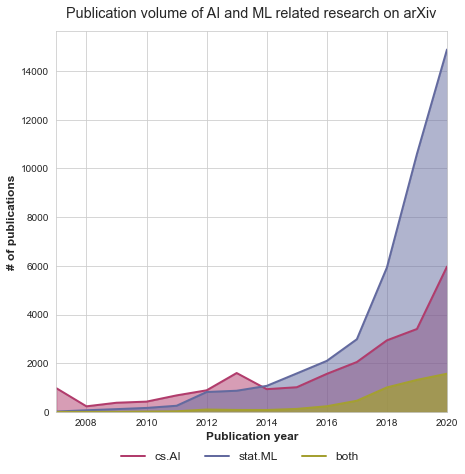

In [25]:
#tabulate number of publications across years
pub_per_year_df = pub_per_year(list(df.cat.unique()),df,"cat")
pub_per_year_df["%_hybrid publications"] = round(pub_per_year_df.both / (pub_per_year_df["stat.ML"] + pub_per_year_df["cs.AI"]),2)*100
pub_per_year_df = pub_per_year_df.fillna(0)
#tabulate year-on-year growth of collaborative work
pub_per_year_df["%_hybrid publications"] = pub_per_year_df["%_hybrid publications"].map(lambda x: f"{x}%")

display(pub_per_year_df.iloc[:,1:])

with sns.axes_style("whitegrid"):
    
    fig, ax = plt.subplots( figsize=(7, 7))
    
    #set meta params
    colors_dict = {"stat.ML": "#636a9f","cs.AI":"#b13c6c","both":"#a4a031"}
    alpha_list = [0.5,0.5,0.7]
    fontweight = "bold"
    fontsize = 12
    
    #subset df (preclude last column with growth rate)
    pubs_df = pub_per_year_df.iloc[:,1:]
    
    #generate plot 
    for idx,cat in enumerate(["cs.AI","stat.ML","both"]):
        df_temp = pubs_df.loc[:,cat]
        ax.plot(df_temp.index,df_temp.values,color = colors_dict[cat],linewidth=2,label=cat)
        ax.fill_between(df_temp.index,0,df_temp.values,color = colors_dict[cat],alpha=alpha_list[idx])
    
    #Format plot 
    title = ax.set_title("Publication volume of AI and ML related research on arXiv",y=1.02,fontweight="normal",fontsize=fontsize*1.2)
    ax.set_xlabel('Publication year',fontweight=fontweight,fontsize=fontsize)
    ax.set_ylabel('# of publications',fontweight=fontweight,fontsize=fontsize)
    ax.legend(loc="lower center", ncol=3,frameon=False,bbox_to_anchor=(0.47, -0.16),prop={'size': 12})
    ax.set_xlim(2007, 2020)
    ax.set_ylim(0, )

    #plt.savefig("Visuals/Fig_1.png",bbox_extra_artists=[title])
    plt.show()

# Methodology 

## Abstract Length Summary Stats (Table 1)

In [26]:
#count words in cleaned abstracts
train["abstract_length"] = train.abstract_clean.map(lambda x: len(x))

#calculate summary stats per subject 
for cat in train.cat.unique():
    df_temp = train.loc[train.cat == cat]
    print("\n","\033[1m" + f"{cat} - Summary Statistics on Abstract Length"+"\033[0m","\n")
    display(pd.DataFrame(df_temp["abstract_length"].describe()).T)
    #print(pd.DataFrame(df_temp["abstract_length"].describe()).T.to_latex(index=False))


 stat.ML - Summary Statistics on Abstract Length 



,count,mean,std,min,25%,50%,75%,max
abstract_length,6400.0,159.201406,50.184438,21.0,123.0,155.0,193.0,449.0



 cs.AI - Summary Statistics on Abstract Length 



,count,mean,std,min,25%,50%,75%,max
abstract_length,6400.0,158.707344,52.625873,8.0,122.0,155.0,193.0,394.0


## Abstract Length Distribution (Figure 4)

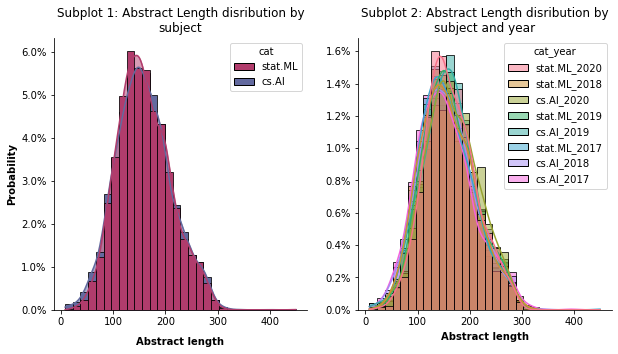

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes = axes.ravel()
fontsize= 10

for idx, i in enumerate(["cat","cat_year"]):
   
    visibility = [False,False,True,True]
    spines = ['top','right','left','bottom']
    frame_zip = zip(spines,visibility)
    
    if i == "cat":
        
        colors = ["#b13c6c","#636a9f"]
        sns.set_palette(sns.color_palette(colors))
        
        axes[idx] = sns.histplot(data=train,x="abstract_length",bins=30,element="bars",kde=True,hue="cat",ax=axes[idx],alpha=1,stat="probability")
        axes[idx].set_ylabel("Probability",fontweight="bold",fontsize=fontsize)
        axes[idx].set_xlabel("Abstract length",fontweight="bold",fontsize=fontsize,labelpad=10)
        axes[idx].set_title("\n".join(wrap(f"Subplot {idx+1}: Abstract Length disribution by subject",45)),fontweight="normal",fontsize=fontsize*1.2) 
        ylabels = [f"{x:.1%}" for x in axes[idx].get_yticks()]
        axes[idx].set_yticklabels(ylabels)

        for i in range(0,2):
            kde_x, kde_y = axes[idx].lines[i].get_data()
            axes[idx].fill_between(kde_x, kde_y,interpolate=True, color=colors[1-i],alpha=0.5)
            
    if i == "cat_year":
        
        axes[idx] = sns.histplot(data=train,x="abstract_length",bins=30,element="bars",kde=True,hue="cat_year",ax=axes[idx],alpha=0.5,stat="probability")
        axes[idx].set_ylabel("",fontweight="bold",fontsize=fontsize)
        axes[idx].set_xlabel("Abstract length",fontweight="bold",fontsize=fontsize,labelpad=5)
        axes[idx].set_title("\n".join(wrap(f"Subplot {idx+1}: Abstract Length disribution by subject and year",45)),fontweight="normal",fontsize=fontsize*1.2)   
        ylabels = [f"{x:.1%}" for x in axes[idx].get_yticks()]
        axes[idx].set_yticklabels(ylabels)
        
    for i in frame_zip:
        axes[idx].spines[i[0]].set_visible(i[1])
                                           

#plt.savefig("Visuals/Fig_5.png")
plt.show()

## Distribution of unigrams and bigrams by class label (Figure 2)

In [36]:
#retrieve number of unique unigrams and bigrams per subject-year combination (8 labels)
dict_test = {}

for gram_label, gram in zip(["unigram_features","bigram_features"],[1,2]):
    
    vocab_train_cat_year,_ = get_ngram_dict(train.abstract_clean,train.cat_year,grams = gram, remove_stopwords = True,verbose = False,n_most_common = 30)

    for k in vocab_train_cat_year.keys():
        
        dict_test[f"{gram_label}-{k}"] = len(vocab_train_cat_year[k].keys())
               
gram_dist_df = pd.DataFrame.from_dict(dict_test,orient="index",columns=["Feature_Count"]).reset_index(drop=False)
gram_dist_df["gram"] =gram_dist_df["index"].map(lambda x: x.split("-")[0])
gram_dist_df["class"] = gram_dist_df["index"].map(lambda x: x.split("-")[1])

print("\n","\033[1m" + "Table used in visualization (Figure 2)"+"\033[0m","\n")
display(gram_dist_df)


 Table used in visualization (Figure 2) 



,index,Feature_Count,gram,class
0,unigram_features-stat.ML_2020,14739,unigram_features,stat.ML_2020
1,unigram_features-stat.ML_2018,14297,unigram_features,stat.ML_2018
2,unigram_features-cs.AI_2020,15992,unigram_features,cs.AI_2020
3,unigram_features-stat.ML_2019,14764,unigram_features,stat.ML_2019
4,unigram_features-cs.AI_2019,15428,unigram_features,cs.AI_2019
5,unigram_features-stat.ML_2017,14113,unigram_features,stat.ML_2017
6,unigram_features-cs.AI_2018,15070,unigram_features,cs.AI_2018
7,unigram_features-cs.AI_2017,14944,unigram_features,cs.AI_2017
8,bigram_features-stat.ML_2020,116447,bigram_features,stat.ML_2020
9,bigram_features-stat.ML_2018,112517,bigram_features,stat.ML_2018


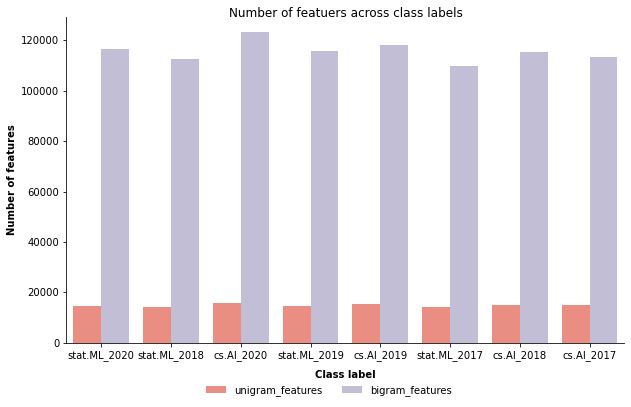


 Summary Stats for unigram_features 

unigram_features-Mean: 14918.38
unigram_features-Std: 600.81

 Summary Stats for bigram_features 

bigram_features-Mean: 115557.0
bigram_features-Std: 4025.25


In [101]:
fig, ax = plt.subplots( figsize=(10,6))

#set meta params
fontsize=10
fontweight="bold"
colors = ['#fb8072', '#bebada']
visibility = [False,False,True,True]
spines = ['top','right','left','bottom']
frame_zip = zip(spines,visibility)


#generate plot
ax = sns.barplot(x="class", y="Feature_Count", hue="gram", data=gram_dist_df,ax=ax,palette=sns.set_palette(colors))

#format plot 
title = ax.set_title(f"Number of featuers across class labels",fontweight="normal",fontsize=fontsize*1.2,y=0.98)  
ax.set_ylabel("Number of features",fontweight="bold",fontsize=fontsize)
ax.set_xlabel("Class label",fontweight="bold",fontsize=fontsize,labelpad=9)
ax.legend(loc="lower center", ncol=2,frameon=False,bbox_to_anchor=(0.47, -0.19))

for i in frame_zip:
    ax.spines[i[0]].set_visible(i[1])
    
#plt.savefig("Visuals/Fig_3.png",bbox_extra_artists=[title])
plt.show()

#plot summary stats
for i in gram_dist_df.gram.unique():
    print("\n","\033[1m"+f"Summary Stats for {i}" + "\033[0m","\n")
    
    df_temp = gram_dist_df.loc[gram_dist_df["gram"] ==i]
    print(f"{i}-Mean: {round(df_temp.Feature_Count.mean(),2)}")
    print(f"{i}-Std: {round(df_temp.Feature_Count.std(),2)}")

## Unique unigram and bigram feature counts contingent on gates (Figure 3)

In [47]:
perc_vocab_dict = defaultdict(dict)

for gram,gram_label in zip([1,2],["unigram","bigram"]):
    
    for perc in [0.05,0.10,0.25,0.5,0.75,1]:
    
        train["abstract_clean_ngram"] = train.abstract_clean.apply(lambda x: abstract_clean2n_gram (x, grams=gram))
        train["abstract_clean_ngram"] = train["abstract_clean_ngram"].apply(lambda x: shorten_abstract (x, perc=perc))
        
        _,_,word_counter = count_words(train.abstract_clean_ngram,remove_stopwords=True)
        
        perc_vocab_dict[gram_label][f"{perc*100}%"] = len(word_counter.keys())
        
        
window_vocab_dict = defaultdict(dict)

train = train.loc[[True if len(a) >5 else False for a in train.abstract_clean]]

for gram,gram_label in zip([1,2],["unigram","bigram"]):

    for window in [0,1,2,3,4]:
        train["abstract_clean_ngram"] = train.abstract_clean.apply(lambda x: abstract_clean2n_gram (x, grams=gram))
        train["abstract_clean_ngram"] = train["abstract_clean_ngram"].map(lambda x: partition_abstract (x, perc = 0.2, section = window))
        
        _,_,word_counter = count_words(train.abstract_clean_ngram,remove_stopwords=True)
        
        window_vocab_dict[gram_label][f"window-{window+1}"] = len(word_counter.keys()) 

        
print("\n","\033[1m"+ "Input for Fig 3 - Subplot 1"+ "\033[0m","\n")
print(perc_vocab_dict)
print("\n","\033[1m"+ "Input for Fig 3 - Subplot 2"+ "\033[0m","\n")
print(window_vocab_dict)


 Input for Fig 3 - Subplot 1 

defaultdict(<class 'dict'>, {'unigram': {'5.0%': 8720, '10.0%': 13407, '25.0%': 22310, '50.0%': 33446, '75.0%': 43022, '100%': 51448}, 'bigram': {'5.0%': 44664, '10.0%': 88670, '25.0%': 201035, '50.0%': 352645, '75.0%': 483760, '100%': 601241}})

 Input for Fig 3 - Subplot 2 

defaultdict(<class 'dict'>, {'unigram': {'window-1': 19749, 'window-2': 21509, 'window-3': 22385, 'window-4': 23128, 'window-5': 24350}, 'bigram': {'window-1': 166158, 'window-2': 179023, 'window-3': 178348, 'window-4': 178003, 'window-5': 180338}})


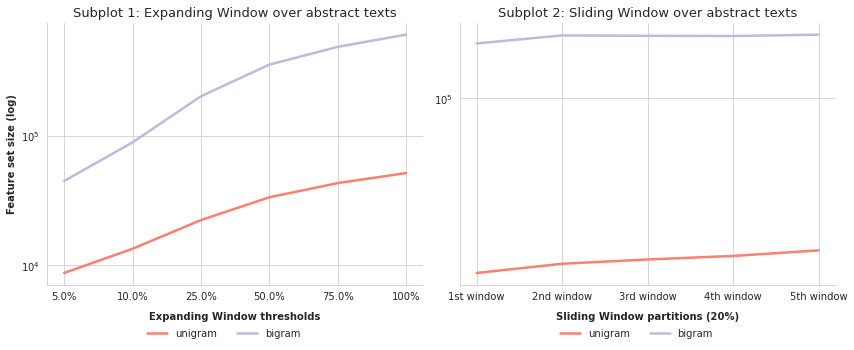

In [102]:
with sns.axes_style("whitegrid"):

    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=None)
    
    axes = axes.ravel()
    
    #define meta params 
    fontsize=10
    fontweight="bold"
    colors = ['#fb8072', '#bebada']
    l_style = ["solid","solid","dotted","dotted"]
    w_labels = ["1st","2nd","3rd","4th","5th"]
    perc_text = [0.05,0.1,0.25,0.5,0.75,1]
    
    #iterate over previously generated dicts 
    for idx, dict_ in enumerate([perc_vocab_dict,window_vocab_dict]):
        
        for i,gram in enumerate(["unigram","bigram"]):
        
            y = list(dict_[gram].values())

            x = [i for i, _ in enumerate(y)]
            
            #generate plot
            axes[idx].plot(x,y,label=gram,color=colors[i],linewidth=2.5,linestyle=l_style[i]) 
            
            visibility = [False,False,True,True]
            frame_zip = zip(spines,visibility)
    
            for i in frame_zip:
                axes[idx].spines[i[0]].set_visible(i[1])
            
            if idx == 0:
                
                #format left plot
                xlabels = [""]+[f"{perc_text[int(i)]*100}%" for i in axes[idx].get_xticks()[1:-1]]+[""]
                axes[idx].set_xticklabels(xlabels)
                
                axes[idx].set_ylabel("Feature set size (log)",fontweight="bold",fontsize=fontsize)
                axes[idx].set_xlabel("Expanding Window thresholds",fontweight="bold",fontsize=fontsize,labelpad=10)
                axes[idx].set_title("Subplot 1: Expanding Window over abstract texts",fontweight="normal",fontsize=fontsize*1.3)
                axes[idx].set_yscale("log")
                
            if idx == 1:   
                
                #format right plot
                axes[idx].set_xticks(np.arange(0, 5, 1.0))
                xlabels = [f"{w_labels[int(i)]} window" for i in axes[idx].get_xticks()]
                axes[idx].set_xticklabels(xlabels)
    
                axes[idx].set_ylabel("",fontweight="bold",fontsize=fontsize)
                axes[idx].set_xlabel("Sliding Window partitions (20%)",fontweight="bold",fontsize=fontsize,labelpad=10)
                axes[idx].set_title("Subplot 2: Sliding Window over abstract texts",fontweight="normal",fontsize=fontsize*1.3)
                axes[idx].set_yscale("log")
                
                for tick in axes[idx].get_xticklabels():
                    tick.set_rotation(0)      
        
        axes[idx].legend(loc="lower center", ncol=2,frameon=False,bbox_to_anchor=(0.47, -0.24))

plt.tight_layout()   
#plt.savefig("Visuals/Fig_4.png")
plt.show()

## Classifier Choice (fasttext embedding scarcity) (in-text)

In [73]:
#Import Fasstext Embeddings (PLEASE NOTE: embeddings kept locally. For replication, please download bin file for English embeddings from https://fasttext.cc/docs/en/crawl-vectors.html)
ft = fasttext.load_model('Data/cc.en.300.bin')   

In [74]:
#retrive unigram vocabulary
word_freq_dict = get_ngram_dict(train.abstract_clean,train.cat_label,grams = 1, remove_stopwords = True,verbose = True,n_most_common = 10,per_class = False)

#retrive fasttext embeddings WITHOUT reconstructed embeddings based on subwords for OOV vocabulary 
emb_dict, oov_dict = fasttext_emb_dict(word_freq_dict, ft, approx_oov=False)

#retrive fasttext embeddings WITH reconstructed embeddings based on subwords for OOV vocabulary 
emb_dict_oov = fasttext_emb_dict(word_freq_dict, ft, approx_oov=True)

most freq 10 OOV words: [('lstm', 325), ('cnns', 271), ('dnns', 271), ('mnist', 254), ('cifar-10', 177), ('imagenet', 175), ("agent's", 157), ('wasserstein', 150), ('relu', 141), ("model's", 140)]
# of unique OOV words: 20959 / 41.0%
# OOV word frequencies: 43341 / 4.0%


In [75]:
#demo inadequacy of approximations based on selected, semantically similar embedding pairs 

#create df mask
ft_df = pd.DataFrame(columns=["word with existing embedding","word with reconstructed embedding","cosine similarity"])

#calculate pairwise cosine similarity for designated pairs
counter=0
for v, oov in zip(["model","activation","sigmoid","explanation"],["model's","relu","relu","explainability"]):
    
    v_i = emb_dict[v]
    v_j = emb_dict_oov[oov]
    
    ft_df.loc[counter,:] = [v,oov,round(cosine_sim(v_i, v_j),4)]
    counter +=1

ft_df
#print(ft_df.to_latex(index=False))

,word with existing embedding,word with reconstructed embedding,cosine similarity
0,model,model's,0.0984
1,activation,relu,0.0508
2,sigmoid,relu,0.0904
3,explanation,explainability,0.1921


# Exploratory Analyses

## Rank Frequency Plots (Figure 6)

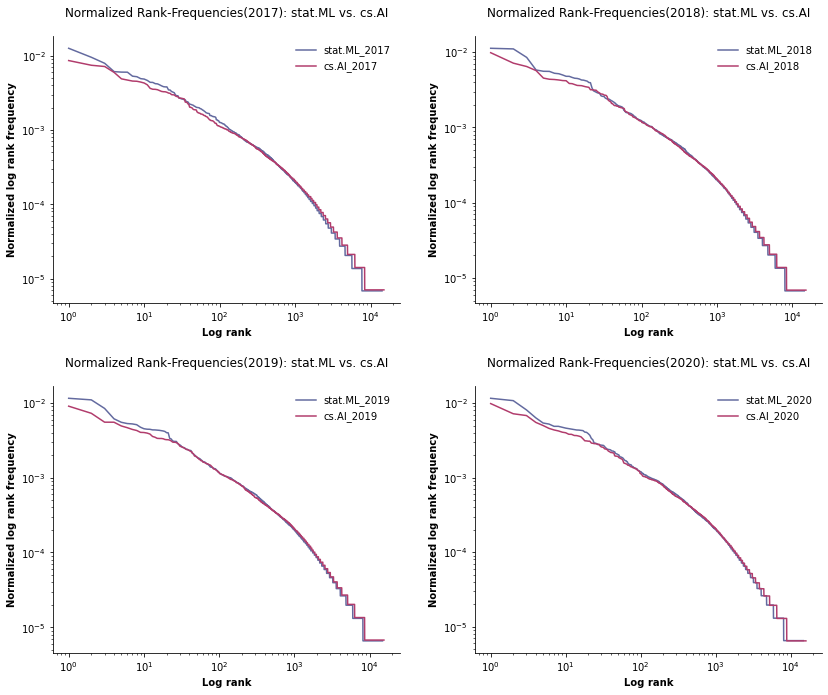

In [16]:
#Return Word Frequencies across subject and years (8 classes)
vocab_train_cat_year,_ = get_ngram_dict(train.abstract_clean,train.cat_year,grams = 1, remove_stopwords = True,verbose = False,n_most_common = 30)

# Initialize dictionary to store rank-frequency distributions
freq_dists = dict()
norm_freq_dists = dict()

years_list = [2017,2018,2019,2020]
colors_dict = {"stat.ML": "#636a9f","cs.AI":"#b13c6c","both":"#a4a031"}
spines = ['top','right','left','bottom']
visibility = [False,False,True,True]
fontweight='bold'
fontsize=10

# Initialize figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

# create subplots per year 
for i, year in enumerate(years_list):
    
    freq_dists[f"stat.ML_{year}"] = [c for w, c in vocab_train_cat_year[f"stat.ML_{year}"].most_common()]
    freq_dists[f"cs.AI_{year}"] = [c for w, c in vocab_train_cat_year[f"cs.AI_{year}"].most_common()]
    
    for label in [f"stat.ML_{year}",f"cs.AI_{year}"]:        
        # Calculate total count
        total = np.sum(freq_dists[label])
       
        # Normalize counts (removing zeros)
        norm_freq_dists[label] = np.array([c / total for c in freq_dists[label]])
        
    # retrieve x and y arrays
    y_ML = [c for c in norm_freq_dists[f"stat.ML_{year}"]]
    y_AI = [c for c in norm_freq_dists[f"cs.AI_{year}"]]
    
    x_ML = [r for r in list(range(1, len(y_ML) + 1))]
    x_AI = [r for r in list(range(1, len(y_AI) + 1))]
    
    # Generate plot    
    axes[i].plot(x_ML, y_ML, label=f"stat.ML_{year}",color=colors_dict["stat.ML"])
    axes[i].plot(x_AI, y_AI, label=f"cs.AI_{year}",color=colors_dict["cs.AI"])
    
    # format plot 
    axes[i].set_title('Normalized Rank-Frequencies({}): stat.ML vs. cs.AI'.format(year),y=1.05,fontweight="normal",fontsize=fontsize*1.2)
    axes[i].set_xlabel('Log rank',fontweight=fontweight,fontsize=fontsize)
    axes[i].set_ylabel('Normalized log rank frequency',fontweight=fontweight,fontsize=fontsize)
    axes[i].set_yscale("log")
    axes[i].set_xscale("log")
    axes[i].legend(frameon=False)
    
    frame_zip = zip(spines,visibility)
    for s in frame_zip:
        axes[i].spines[s[0]].set_visible(s[1])
    
fig.tight_layout(pad=2.0)
#plt.savefig("Visuals/Fig_6.png")
plt.show()

## Change in set of most frequent n-grams (Table 3 & 4)

In [54]:
results_yoy = defaultdict(list)
results_tobase = defaultdict(list)
gram_list =["unigrams","bigrams","trigrams"]


most_freq = 30

for i in range(1,4):
    
    #retrive most freq words and bring into tabular form
    vocab,_ = get_ngram_dict(train.abstract_clean,train.cat_year, grams = i, remove_stopwords = True,verbose = False,n_most_common = 20)
    temp_df = tabulate_freq_words("",vocab,most_freq=most_freq,count=False,filter_label =False)
    
    
    for cat in ["cs.AI","stat.ML"]:
        
        base =list()
        
        #create lists of cols to iterate over with lag of 1 for YoY calc
        cols_1 = [col for col in temp_df.columns if cat in col][:-1]
        cols_2 = [col for col in temp_df.columns if cat in col][1:]
        
        for y1,y2 in zip(cols_1,cols_2): 
    
            base.append(y1)
            
            #retrieve most freq words sets for year, year+1 and base
            set_1 = set(temp_df.loc[:,y1])
            set_2 = set(temp_df.loc[:,y2])
            set_base = set(temp_df.loc[:,base[0]])
           
            #calculate intersections as measure of temporal persistence
            calc_yoy = round(len(set_1.intersection(set_2))/len(set_1),2)
            calc_base = round(len(set_base.intersection(set_2))/len(set_base),2)
            
            #convert to df
            results_yoy[f"{cat}_%Change_top {most_freq}_{gram_list[i-1]}"].append(calc_yoy)
            results_tobase[f"{cat}_%Change_top {most_freq}_{gram_list[i-1]}"].append(calc_base)
            
#format dfs             
yoy_df= pd.DataFrame.from_dict(results_yoy).T
yoy_df.columns = ["2017-2018","2018-2019","2019-2020"]
#yoy_df = yoy_df.applymap(lambda x: round(1-x,2))
yoy_df=yoy_df.applymap(lambda x: f"{str(round(x,2)*100)}%")
print("\n","\033[1m"+ "Table 3 (Year-on-Year)"+ "\033[0m","\n")
display(yoy_df)
#print(yoy_df.to_latex())

tobase_df= pd.DataFrame.from_dict(results_tobase).T
tobase_df.columns = ["2017-2018","2017-2019","2017-2020"]
#tobase_df = tobase_df.applymap(lambda x: round(1-x,2))
tobase_df=tobase_df.applymap(lambda x: f"{str(round(x*100,2))}%")
print("\n","\033[1m"+ "Table 4 (from base (2017))"+ "\033[0m","\n")
display(tobase_df)
#print(tobase_df.to_latex())


 Table 3 (Year-on-Year) 



,2017-2018,2018-2019,2019-2020
cs.AI_%Change_top 30_unigrams,83.0%,97.0%,97.0%
stat.ML_%Change_top 30_unigrams,87.0%,100.0%,97.0%
cs.AI_%Change_top 30_bigrams,83.0%,77.0%,87.0%
stat.ML_%Change_top 30_bigrams,70.0%,90.0%,70.0%
cs.AI_%Change_top 30_trigrams,63.0%,67.0%,63.0%
stat.ML_%Change_top 30_trigrams,73.0%,80.0%,70.0%



 Table 4 (from base (2017)) 



,2017-2018,2017-2019,2017-2020
cs.AI_%Change_top 30_unigrams,83.0%,83.0%,80.0%
stat.ML_%Change_top 30_unigrams,87.0%,87.0%,87.0%
cs.AI_%Change_top 30_bigrams,83.0%,80.0%,77.0%
stat.ML_%Change_top 30_bigrams,70.0%,70.0%,77.0%
cs.AI_%Change_top 30_trigrams,63.0%,60.0%,50.0%
stat.ML_%Change_top 30_trigrams,73.0%,63.0%,57.0%


## Jaccard Similarities (Figure 7)

Jaccrard Similarity - unigram


,cs.AI,stat.ML
cs.AI,1.000000,0.279039
stat.ML,0.279039,1.000000


Jaccrard Similarity - bigram


,cs.AI,stat.ML
cs.AI,1.000000,0.088699
stat.ML,0.088699,1.000000


Jaccrard Similarity - trigram


,cs.AI,stat.ML
cs.AI,1.000000,0.012171
stat.ML,0.012171,1.000000


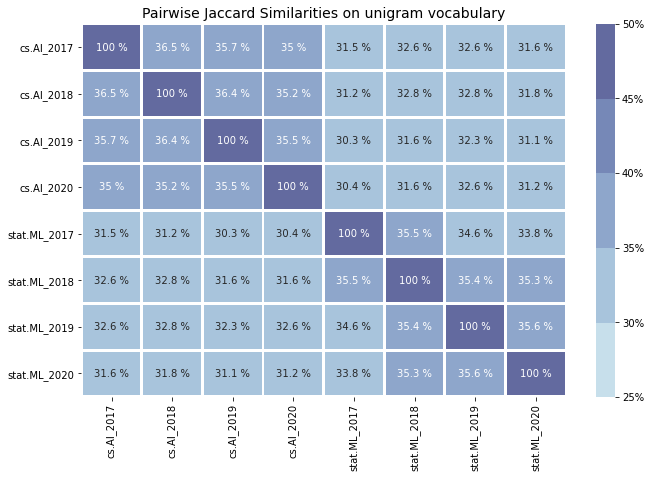

In [105]:
#calculate Jaccard Sim for unigrams / bigrams / trigrams
for gram_label, gram in zip(["unigram","bigram","trigram"],[1,2,3]):
    
    print("\033[1m" + f"Jaccrard Similarity - {gram_label}"+"\033[0m")

    vocab_train_uni,n_posts_uni = get_ngram_dict(train.abstract_clean,train.cat, grams = gram, remove_stopwords = True,verbose = False,n_most_common = 30)
    
    display(tabulate_jaccard_sim(label2id,vocab_train_uni,rounding=False))

#retrieve unigram vocab across subject-year combinations
vocab_train_uni_cat_year,_ = get_ngram_dict(train.abstract_clean,train.cat_year, grams = 1, remove_stopwords = True,verbose = False,n_most_common = 30)

#tabulate pairwise jaccard similarities between subject-year cominations (8 classes)
jac_df = tabulate_jaccard_sim(label2id_year,vocab_train_uni_cat_year,rounding=True)
jac_df = jac_df.applymap(lambda x: x* 100)

#create custom color map
colors = ['#c7dfeb', '#9ebbd7', '#7d92bf', '#636a9f']
# Discretizes the interpolation into bins
n_bins = 5 
cm = LinearSegmentedColormap.from_list(_, colors, N=n_bins)

fig, ax = plt.subplots(figsize=(10,7))
fig.tight_layout(pad=2.0)

#generate plot
ax = sns.heatmap(jac_df,annot = True, fmt = 'g',linewidths=2,cmap=cm,cbar_kws={'format': '%.0f%%', 'ticks': np.arange(25,51,step=5)},vmax=50,vmin=25)

#format plot 
ax.set_title("Pairwise Jaccard Similarities on unigram vocabulary",fontweight="normal",y=1.01,fontsize=14)
for t in ax.texts: t.set_text(t.get_text() + " %")

fig.tight_layout(pad=2.0)
#plt.savefig("Visuals/Fig_7.png")
plt.show()

## Mutual Information on n-grams (Appendix 1)

In [70]:
docs_per_label = dict(train.cat_label.value_counts())
print(f"Documents per class: {docs_per_label}")
print(f"Class labels: {label2id}")

mi_df_list = list()

# calculate mutual information for unigrams, bigrams & trigrams
for gram_label, gram in zip(["uni","bi","tri"],[1,2,3]):
    
    # retrive number of times each word occurs per class ("n_posts")
    vocab,n_posts = get_ngram_dict(train.abstract_clean,train.cat_label, grams = gram, remove_stopwords = True,verbose = False,n_most_common = 30)
    
    mi_list= sorted([(mi(w, n_posts,docs_per_label,0,1), w) for w in set(vocab[0]).intersection(set(vocab[1]))], reverse=True)
    
    #append results to list
    mi_df_list.append(tabulate_mi_per_label(label2id,"stat.ML","cs.AI",mi_list,n_posts,size=10))

#convert list tf
df_concat = pd.concat(mi_df_list, axis=1)
df_concat.columns = ["stat.ML_unigram","cs.AI_unigram","stat.ML_bigram","cs.AI_bigram","stat.ML_trigram","cs.AI_trigram"]
print("\n","\033[1m" +"Top 10 words based on MI by class label (descending order)"+"\033[0m")

df_concat

###### LATEX ######
#df_concat = pd.concat(mi_df_list[:-1], axis=1)
#print(df_concat.to_latex(index=False))
#for i in mi_df_list:
#    print(i.to_latex(index=False))

Documents per class: {1: 6400, 0: 6400}
Class labels: {'cs.AI': 0, 'stat.ML': 1}

 Top 10 words based on MI by class label (descending order)


,stat.ML_unigram,cs.AI_unigram,stat.ML_bigram,cs.AI_bigram,stat.ML_trigram,cs.AI_trigram
0,"(data,)","(ai,)","(neural, networks)","(artificial, intelligence)","(stochastic, gradient, descent)","(artificial, intelligence, ai)"
1,"(gaussian,)","(intelligence,)","(machine, learning)","(reinforcement, learning)","(deep, neural, networks)","(deep, reinforcement, learning)"
2,"(regression,)","(agents,)","(gradient, descent)","(intelligence, ai)","(principal, component, analysis)","(reinforcement, learning, rl)"
3,"(matrix,)","(reasoning,)","(stochastic, gradient)","(deep, reinforcement)","(machine, learning, models)","(monte, carlo, tree)"
4,"(gradient,)","(human,)","(numerical, experiments)","(natural, language)","(empirical, risk, minimization)","(carlo, tree, search)"
5,"(convergence,)","(agent,)","(real, data)","(question, answering)","(synthetic, real, data)","(visual, question, answering)"
6,"(linear,)","(language,)","(gaussian, process)","(knowledge, base)","(markov, chain, monte)","(neural, machine, translation)"
7,"(distribution,)","(logic,)","(variational, inference)","(ai, systems)","(chain, monte, carlo)","(question, answering, vqa)"
8,"(descent,)","(reinforcement,)","(component, analysis)","(knowledge, representation)","(generative, adversarial, networks)","(reinforcement, learning, drl)"
9,"(stochastic,)","(planning,)","(convergence, rate)","(tree, search)","(convolutional, neural, networks)","(natural, language, understanding)"


## Jaccard Similarities (Figure 8)

Input for Figure 8


,index,cs.AI_2017,cs.AI_2018,cs.AI_2019,cs.AI_2020,stat.ML_2017,stat.ML_2018,stat.ML_2019,stat.ML_2020
0,cs.AI_2017,0.00,0.08,0.09,0.10,0.30,0.25,0.23,0.26
1,cs.AI_2018,0.08,0.00,0.08,0.09,0.33,0.26,0.24,0.28
2,cs.AI_2019,0.09,0.08,0.00,0.08,0.36,0.29,0.27,0.30
3,cs.AI_2020,0.10,0.09,0.08,0.00,0.34,0.27,0.25,0.27
4,stat.ML_2017,0.29,0.32,0.34,0.33,0.00,0.08,0.09,0.10
5,stat.ML_2018,0.23,0.25,0.27,0.25,0.09,0.00,0.07,0.08
6,stat.ML_2019,0.22,0.23,0.25,0.23,0.10,0.07,0.00,0.07
7,stat.ML_2020,0.24,0.26,0.28,0.25,0.10,0.08,0.07,0.00


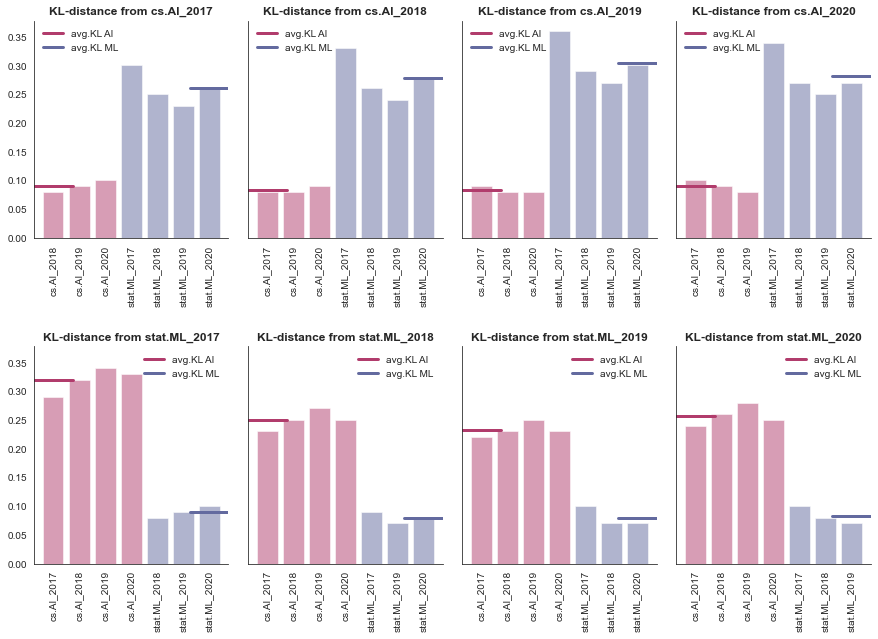

In [66]:
#retrive unigram vocab per subject and year (8 classes)
vocab_train_cat_year,_ = get_ngram_dict(train.abstract_clean,train.cat_year,grams = 1, remove_stopwords = True,verbose = False,n_most_common = 30)

#retrieve labels for pairwise combarisons
cat_year_list = sorted(list(vocab_train_cat_year.keys()))

sim_dict = defaultdict(list)

#calculate pairwise distance measures (entropy, cross-entropy and KL-divergence)
for cat1 in cat_year_list:
    
    for cat2 in cat_year_list:
        
        #only retain KL-divergence
        sim_dict[cat1].append(calc_sim_measures(cat1,cat2,vocab_train_cat_year)[-1])   

#convert into df
df_sim =pd.DataFrame.from_dict(sim_dict, orient='index', columns=cat_year_list).reset_index()

df_sim = df_sim.loc[[True if "both" not in i else False for i in df_sim["index"]],[col for col in df_sim.columns if "both" not in col]]

print("\033[1m" + "Input for Figure 8"+"\033[0m")
display(df_sim)


with sns.axes_style("white"):
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 13),sharey=True)
    fig.subplots_adjust(left=None, bottom=0.3, right=None, top=None, wspace=0.1, hspace=0.5)
    
    #specify legend locations per plot for lookup
    loc = [2]*4 + [1]*4
    
    axes = axes.ravel()
    
    counter = 0
    for i,r in df_sim.iterrows():
        
        #compare on class against remainder
        label = list(r)[0]
        y = list(r)[1:]
        y.pop(counter)
        x = list(df_sim.columns)[1:]
        x.pop(counter)
        
        #calculate averages
        avg_ai = np.mean([i for idx,i in enumerate(y) if "cs.AI" in x[idx]])
        avg_ml = np.mean([i for idx,i in enumerate(y) if "stat.ML" in x[idx]])
        
        #retrive colors conditional on comparison candidates
        col_list = ["#b13c6c" if "cs.AI" in i else "#636a9f" for i in x]
    
        #generate plot
        axes[counter].bar(x,y,color = col_list,alpha=0.5)
        axes[counter].axhline(avg_ai,0,0.2, color="#b13c6c", linewidth=3,alpha=1,label="avg.KL AI")
        axes[counter].axhline(avg_ml,0.8,1, color="#636a9f", linewidth=3,alpha=1,label="avg.KL ML")
        
        #formal plot
        axes[counter].set_title(f"KL-distance from {label}",fontweight="bold")
        for tick in axes[counter].get_xticklabels():
            tick.set_rotation(90)  
        axes[counter].legend(prop={'size': 10},frameon=False,loc=loc[counter])
        
        counter += 1
        
        sns.despine()
    
    #plt.savefig("Visuals/Fig_8.png")
    plt.show()

## t-SNE Plots (Figures 9 & 10)

In [76]:
# Generate new column in dataframe containing review embeddings
train['abstract_clean_vec'] = train['abstract_clean'].apply(lambda x: abstract2vec(x,emb_dict))

In [77]:
# Create dataset of vectors for t-SNE
tsne_vectors = np.array(list(train['abstract_clean_vec']))

# Train t-SNE
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(tsne_vectors)

Figure 9


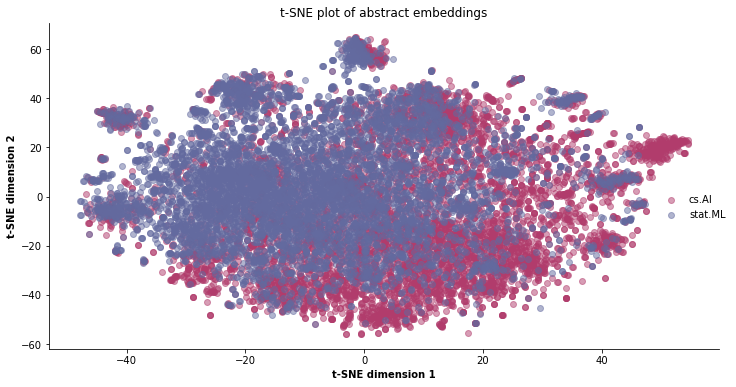

Figure 10


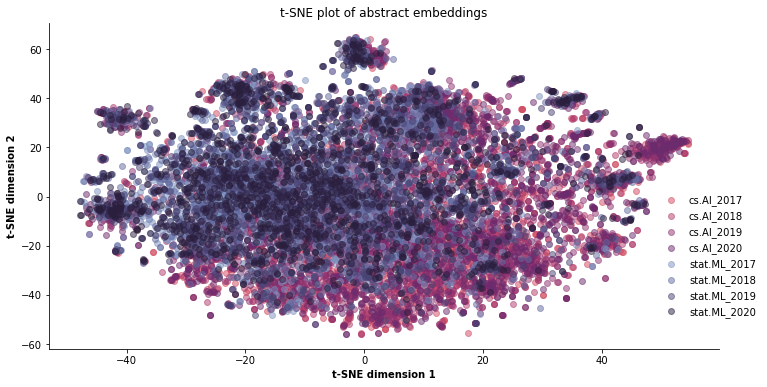

In [79]:
fig, ax = plt.subplots(1, figsize=(12, 6))

#specify meta params
colors = ["#b13c6c","#636a9f"]
spines = ['top','right','left','bottom']
visibility = [False,False,True,True]

#generate plot
for l in list(id2label):
    ax.scatter(tsne_results[train["cat_label"]==l, 0], tsne_results[train["cat_label"]==l, 1], label=id2label[l], alpha=0.5,color =colors[l])
    ax.set_title('t-SNE plot of abstract embeddings')
    ax.set_xlabel('t-SNE dimension 1',fontweight="bold")
    ax.set_ylabel('t-SNE dimension 2',fontweight="bold")
    
    ax.legend(frameon=False,ncol=1,bbox_to_anchor=(0.9, 0.5))
    
#format plot     
frame_zip = zip(spines,visibility)
for s in frame_zip:
    ax.spines[s[0]].set_visible(s[1])

    
print("\033[1m" + "Figure 9" +"\033[0m")
#plt.savefig("Visuals/Fig_9.png")
plt.show()

colors=['#d14a61', '#b13c6c', '#8f3371', '#6c2b6d','#7d92bf', '#636a9f', '#494373', '#2b1f3e']

# Plot results
fig, ax = plt.subplots(1, figsize=(12, 6))

#generate plot
for l in list(id2label_year):
    ax.scatter(tsne_results[train["cat_year_label"]==l, 0], tsne_results[train["cat_year_label"]==l, 1], label=id2label_year[l], alpha=0.5 ,color =colors[l])
    ax.set_title('t-SNE plot of abstract embeddings')
    ax.set_xlabel('t-SNE dimension 1',fontweight="bold")
    ax.set_ylabel('t-SNE dimension 2',fontweight="bold")
    ax.legend(frameon=False,ncol=1,bbox_to_anchor=(0.9, 0.5))
    
#format plot
frame_zip = zip(spines,visibility)
for s in frame_zip:
    ax.spines[s[0]].set_visible(s[1])
                                
print("\033[1m" + "Figure 10"+"\033[0m")     
#plt.savefig("Visuals/Fig_10.png")
plt.show()

## Nearest Neighbors Purity (Figure 11)

In [84]:
#take stratified sample of 160 units (20 per year and subject)
train_sub = sample_df(train,2017,20,verbose = True )

,cs.AI,stat.ML
2017,20,20
2018,20,20
2019,20,20
2020,20,20


In [85]:
#calculate NN purity for subject-year combinations (with reference to correct subject irrespective of year)
nn_1 = nn_homogen(train_sub,"cat_year","cat",n_nb=5)

In [86]:
#calculate NN purity for subjects in the aggregate (with reference to correct subject irrespective of year)
nn_2 = nn_homogen(train_sub,"cat","cat",n_nb=5)

In [87]:
#calculate NN purity for subject-year combinations (with reference to correct subject-year combination)
nn_3 = nn_homogen(train_sub,"cat_year","cat_year",n_nb=5)

Input for Figure 11 



,label,category,nn_Homogenity
0,cs.AI_2017,label2category,0.5500
1,cs.AI_2018,label2category,0.4000
2,cs.AI_2019,label2category,0.4500
3,cs.AI_2020,label2category,0.4900
4,stat.ML_2017,label2category,0.7100
5,stat.ML_2018,label2category,0.6900
6,stat.ML_2019,label2category,0.7400
7,stat.ML_2020,label2category,0.6300
8,cs.AI_2017,category2category,0.4725
9,cs.AI_2018,category2category,0.4725


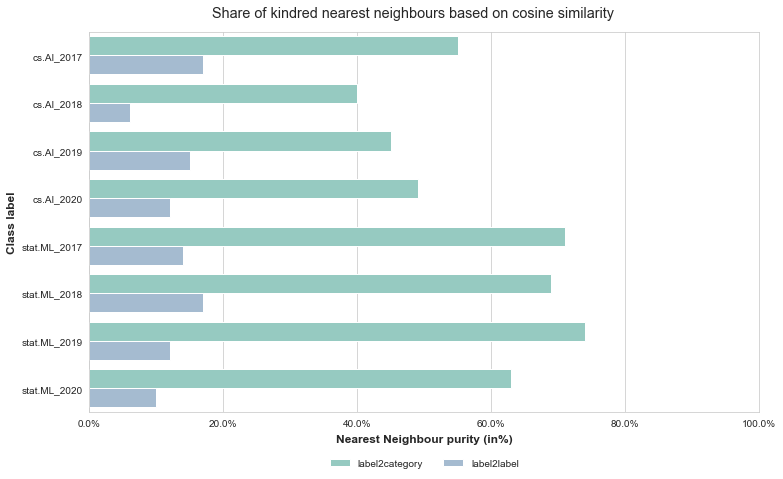

In [106]:
nn_tot = nn_1.copy()

temp_list= list()
for i in nn_1.label:
    if "cs.AI" in i:
        temp_list.append(nn_2.loc[nn_2.label == "cs.AI","match"].item())
    else:
        temp_list.append(nn_2.loc[nn_2.label == "stat.ML","match"].item())

nn_tot["category2category"] = temp_list

nn_tot = nn_tot.merge(nn_3["match"], how='left', left_index=True, right_index=True)

nn_tot.columns = ["label","label2category","category2category","label2label"]

nn_tot_melt = pd.melt(frame =nn_tot,id_vars="label",var_name="category",value_name="nn_Homogenity")

nn_tot_melt_sub = nn_tot_melt.loc[nn_tot_melt.category != "category2category"]

print("\033[1m" + "Input for Figure 11"+"\033[0m","\n") 
display(nn_tot_melt)
print("\n")

with sns.axes_style("whitegrid"):
    
    #set meta params
    fontweight="bold"
    col_pal = ['#8dd3c7', '#9ebbd7', '#636a9f']
    fontsize=12
        
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(12,7))
    
    f.suptitle("Share of kindred nearest neighbours based on cosine similarity",y=0.93,fontsize=fontsize*1.2)
    
    #generate plot 
    ax = sns.barplot(x="nn_Homogenity", y="label",hue="category",data=nn_tot_melt_sub,ax=ax, palette = sns.set_palette(col_pal))
    
    #format plot
    ax.set_xlim(0,1) 
    ax.legend(loc="lower center", ncol=3,frameon=False,bbox_to_anchor=(0.5, -0.17))
    ax.set_xlabel("Nearest Neighbour purity (in%)",fontweight = fontweight,fontsize=fontsize,labelpad=6)
    ax.set_ylabel("Class label",fontweight = fontweight,fontsize=fontsize)
    xlabels = [f"{x:.1%}" for x in ax.get_xticks()]
    ax.set_xticklabels(xlabels)
    
    fig.tight_layout(pad=2.0)
    #plt.savefig("Visuals/Fig_11.png")
    plt.show()

# Classification Experiments

## Experiment 1 - Full Abstract Classification

In [250]:
#instantiate object to capture model results 
results_dict_fp = defaultdict(dict)

#instantiate object capturing output in visualiztion-friendly formate 
viz_dict_fp = {}
viz_dict_fp["most_freq"] = defaultdict(list)
viz_dict_fp["mutual_info"] = defaultdict(list)

# CLEAN - remove stopwords from cleaned abstracts (tokenized,no punctuation, no blank spaces)
for data in [train, dev, test]:

    data["abstract_clean"] = data.abstract_clean.apply(lambda x: rem_stopwords(x))

# CLEAN - only retain abstracts of length >= 5 (dev & test sets are fine)
train = train.loc[[True if len(a) >=5 else False for a in train.abstract_clean]]

#>>>>>>>> HYPERPARAM 1 - Future Pruning: Most Freq vs. Mutual Information <<<<<<<<<<
for prune_tech in ["most_freq","mutual_info"]:

#>>>>>>>> HYPERPARAM 2 - UNIGRAM vs. BIGRAM Features <<<<<<<<<<

    for gram_label, gram in zip(["unigram","bigram"],[1,2]):
    
        for data in [train, dev, test]:
            
            data["abstract_clean_ngram"] = data.abstract_clean.apply(lambda x: abstract_clean2n_gram (x, grams=gram))
           
        #PREPARE - construct look-up dictionaries from cleaned abstracts (sored by most freq. occuring words)
        
        if prune_tech == "most_freq":
        
            w2id,id2w,_ = count_words(train.abstract_clean_ngram,remove_stopwords=True)
        
        if prune_tech == "mutual_info":
        
            w2id,id2w,_ = get_mi_per_label_lookup (train,label2id,"stat.ML","cs.AI",gram=gram)
            
            # PREPARE - only retain tokens in training dataset sequences that are in mi_vocab
            mi_vocab = dict.fromkeys(w2id, 0)
            train["abstract_clean_ngram"] = train["abstract_clean_ngram"].map(lambda x:oov_rem (x,mi_vocab))
    
        #>>>>>>>> HYPERPARAM 3 - Amount of Features to select <<<<<<<<<<
        
        for size in [10,100,500,1000,2500,5000,10000]:
        
            # retrieve amount of features to consider
            top_k_features = sorted(id2w)[:size]
            
            #ENCODE-1 - convert cleaned abstracts into integer representations based on look-up dict
            for data in [train, dev, test]: 
                
                data["abstract_enc"] = data.abstract_clean_ngram.apply(lambda x: encode_abstract(x, w2id))
                
                #Run time saving function - reduce abstract sequences only to tokens that are among the k features to speed up lookup 
                data["abstract_enc"] = data.abstract_enc.apply(lambda x: abstract_enc_redux(x,size))
                
                #ENCODE-2 - convert each abstract into sparse vector representation based on look-up dict
                data['sparse'] = data.abstract_enc.map(lambda x: sent2sparse(x,top_k_features))
                         
            ########### MODELING ########### 
            
            # Define device
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            
            #>>>>>>>> HYPERPARAM 4 - 2 vs. 8 class classification problem <<<<<<<<<<
            
            for label_dict,label in zip([label2id,label2id_year],["cat","cat_year"]):
        
                
                start = time.time()
                
                print("\033[1m" + f"Running model config: {gram_label}, {prune_tech} pruning, {len(train[label].unique())} labels, {size} features..." +"\033[0m")
                    
                # Transform all data to torch tensors
                train_x = torch.tensor(list(train["sparse"])).float()
                train_y = torch.tensor([label_dict[p] for p in train[label]])
                dev_x = torch.tensor(list(dev["sparse"])).float()
                dev_y = torch.tensor([label_dict[p] for p in dev[label]])
                test_x = torch.tensor(list(test["sparse"])).float()
                test_y = torch.tensor([label_dict[p] for p in test[label]])
                
                # Define model dimensions
                input_dim = size
                output_dim = len(train[label].unique())
                
                # Train and evaluate model
                
                classifier = LRClassifier(input_dim, output_dim)
                acc_test,val_accs,true_lr, pred_lr = train_classifier(classifier, train_x, train_y, dev_x, dev_y, test_x, test_y, device)
                      
                #Store Results 
            
                viz_dict_fp[prune_tech][f"{label}_{gram_label}"].append(acc_test)
                
                results_dict_fp[f"{prune_tech}-{gram_label}-{label}-{size}"]["Test_Acc"] = acc_test
                results_dict_fp[f"{prune_tech}-{gram_label}-{label}-{size}"]["Val_Acc"] = val_accs
                results_dict_fp[f"{prune_tech}-{gram_label}-{label}-{size}"]["Top20_Predictors"] = [[id2w[i+2] for i in l] for l in classifier.linear.weight.topk(k=min(size,20), dim=-1)[1].tolist()]
                results_dict_fp[f"{prune_tech}-{gram_label}-{label}-{size}"]["True_Labels"] = true_lr
                results_dict_fp[f"{prune_tech}-{gram_label}-{label}-{size}"]["Pred_Labels"] = pred_lr
                
                end = time.time()
                print(f"Execution Time ...{end - start}")
            

Running model config: unigram, most_freq pruning, 2 labels, 10 features...
Accuracy on dev data after 05 epochs: 0.4881
Accuracy on dev data after 10 epochs: 0.4944
Accuracy on dev data after 15 epochs: 0.5188
Accuracy on dev data after 20 epochs: 0.5594
Accuracy on test data: 0.5863
Execution Time ...0.18386602401733398
Running model config: unigram, most_freq pruning, 8 labels, 10 features...
Accuracy on dev data after 05 epochs: 0.1550
Accuracy on dev data after 10 epochs: 0.1587
Accuracy on dev data after 15 epochs: 0.1631
Accuracy on dev data after 20 epochs: 0.1675
Accuracy on test data: 0.1475
Execution Time ...0.06499218940734863
Running model config: unigram, most_freq pruning, 2 labels, 100 features...
Accuracy on dev data after 05 epochs: 0.6806
Accuracy on dev data after 10 epochs: 0.7094
Accuracy on dev data after 15 epochs: 0.7206
Accuracy on dev data after 20 epochs: 0.7144
Accuracy on test data: 0.7219
Execution Time ...0.1324007511138916
Running model config: unigram, 

### Top 5 most predictive unigrams and bigrams (Appendix 2)

In [301]:
#instantiate empty list to capture results df
df_list = list()

#iterate over unigram and bigram model results
for gram in ["unigram","bigram"]:
    
    counter=0
    
    #setup gram df
    col_list=["#_features","label",f"Top_{gram}"]
    df = pd.DataFrame(columns = col_list)
    
    #iterate over feature set sizes to retrive model results for given gram 
    for f in [10,100,500,1000,2500,5000,10000]:
        predictors = results_dict_fp[f"mutual_info-{gram}-cat-{f}"]["Top20_Predictors"]
       
        #add top 5 predictors per feature-gram-label combination
        for idx,k in enumerate(predictors):
            
            df.loc[counter,:] = [f,id2label[idx],k[:5]]
        
            counter +=1
    
    #append results to df list
    df_list.append(df)

#convert list to df
df_g1 = df_list[0].merge(df_list[1].loc[:,["Top_bigram"]],left_index=True,right_index=True)
df_g1.style.set_properties(subset=["Top_unigram","Top_bigram"], **{'width': '300px'})

#print(df_g1.to_latex(index=False))

,#_features,label,Top_unigram,Top_bigram
0,10,cs.AI,"['human', 'regression', 'matrix', 'ai', 'data']","[('intelligence', 'ai'), ('natural', 'language'), ('reinforcement', 'learning'), ('deep', 'reinforcement'), ('machine', 'learning')]"
1,10,stat.ML,"['matrix', 'regression', 'gaussian', 'gradient', 'agents']","[('gradient', 'descent'), ('neural', 'networks'), ('machine', 'learning'), ('stochastic', 'gradient'), ('numerical', 'experiments')]"
2,100,cs.AI,"['programming', 'artificial', 'logic', 'intelligence', 'games']","[('genetic', 'algorithm'), ('intelligent', 'systems'), ('knowledge', 'bases'), ('action', 'space'), ('ai', 'systems')]"
3,100,stat.ML,"['variational', 'loss', 'synthetic', 'stochastic', 'high-dimensional']","[('predictive', 'performance'), ('model', 'selection'), ('high-dimensional', 'data'), ('optimal', 'transport'), ('posterior', 'distribution')]"
4,500,cs.AI,"['propositional', 'checking', 'rules', 'fuzzy', 'describes']","[('probabilistic', 'reasoning'), ('social', 'choice'), ('visual', 'features'), ('tasks', 'requiring'), ('learning', 'artificial')]"
5,500,stat.ML,"['bandits', 'statistics', 'variational', 'pca', 'smooth']","[('problem', 'estimating'), ('random', 'variable'), ('total', 'variation'), ('high', 'dimensional'), ('inference', 'problems')]"
6,1000,cs.AI,"['creates', 'compilation', 'conflict', 'fuzzy', 'express']","[('bayesian', 'networks'), ('learning', 'artificial'), ('dempster-shafer', 'theory'), ('makes', 'difficult'), ('recent', 'deep')]"
7,1000,stat.ML,"['screening', 'package', 'finance', 'initialized', 'attain']","[('sampling', 'algorithm'), ('update', 'rule'), ('high', 'confidence'), ('algorithm', 'provide'), ('networks', 'provide')]"
8,2500,cs.AI,"['metaheuristic', 'detected', 'counter', 'unintended', 'ignorance']","[('past', 'data'), ('real', 'human'), ('paper', 'aim'), ('program', 'analysis'), ('analysis', 'technique')]"
9,2500,stat.ML,"['wifi', 'framed', 'investors', 'epidemiology', 'posits']","[('setting', 'propose'), ('image', 'domain'), ('unsupervised', 'fashion'), ('topic', 'model'), ('lstm', 'model')]"


### Experiment 1 Confusion Matrix (Figure 12)

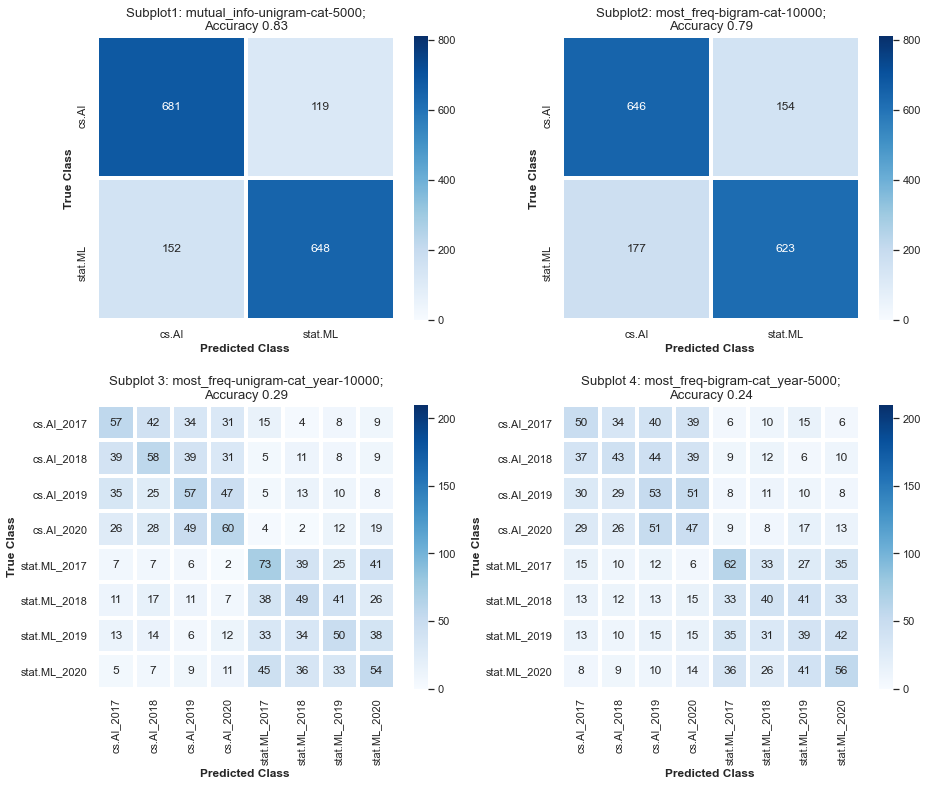


 Classification Report: mutual_info-unigram-cat-5000 

              precision    recall  f1-score   support

       cs.AI       0.82      0.85      0.83       800
     stat.ML       0.84      0.81      0.83       800

    accuracy                           0.83      1600
   macro avg       0.83      0.83      0.83      1600
weighted avg       0.83      0.83      0.83      1600


 Classification Report: most_freq-bigram-cat-10000 

              precision    recall  f1-score   support

       cs.AI       0.78      0.81      0.80       800
     stat.ML       0.80      0.78      0.79       800

    accuracy                           0.79      1600
   macro avg       0.79      0.79      0.79      1600
weighted avg       0.79      0.79      0.79      1600


 Classification Report: most_freq-unigram-cat_year-10000 

              precision    recall  f1-score   support

  cs.AI_2017       0.30      0.28      0.29       200
  cs.AI_2018       0.29      0.29      0.29       200
  cs.AI_2019 

In [283]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

# define meta params 
fontsize=12
fontweight="bold"
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.3)
#list of top models (1 per series)
best_models = ['mutual_info-unigram-cat-5000','most_freq-bigram-cat-10000','most_freq-unigram-cat_year-10000','most_freq-bigram-cat_year-5000']

for idx,model in enumerate(best_models):

    #calculate confusion matrix 
    y_true = results_dict_fp[model]['True_Labels']
    y_pred = results_dict_fp[model]['Pred_Labels']
    
    cm = confusion_matrix(y_true,y_pred)
    
    #generate & format plot for top 2 quadrants of confusion matrix plot (2-class classification)
    if idx in [0,1]:
        
        axes[idx] = sns.heatmap(cm,annot = True, fmt = 'g',linewidth=3,cmap="Blues",ax=axes[idx], cbar_kws={'ticks': np.arange(0,810,step=200)},vmax=810,vmin=0)
       
        xlabels = [idx for idx,_ in enumerate(axes[idx].get_xticks())]
        axes[idx].set_xticklabels([id2label[i]for i in xlabels])
        ylabels = [idx for idx,_ in enumerate(axes[idx].get_xticks())]
        axes[idx].set_yticklabels(ylabels)
        axes[idx].set_yticklabels([id2label[i]for i in xlabels])
        axes[idx].set_title("\n".join(wrap(f"Subplot{idx+1}: {model}; Accuracy {round(results_dict_fp[model]['Test_Acc'],2)}",40)),fontweight="normal",fontsize=fontsize*1.1)
        axes[idx].set_xlabel("Predicted Class ",fontsize=fontsize,fontweight=fontweight)
        axes[idx].set_ylabel("True Class",fontsize=fontsize,fontweight=fontweight)
    
    #generate & format plot for top 2 quadrants of confusion matrix plot (8-class classification)
    else:
        
        axes[idx] = sns.heatmap(cm,annot = True, fmt = 'g',linewidth=3,cmap="Blues",ax=axes[idx], cbar_kws={'ticks': np.arange(0,210,step=50)},vmax=210,vmin=0)
        
        xlabels = [idx for idx,_ in enumerate(axes[idx].get_xticks())]
        axes[idx].set_xticklabels([id2label_year[i]for i in xlabels])
        ylabels = [idx for idx,_ in enumerate(axes[idx].get_xticks())]
        axes[idx].set_yticklabels([id2label_year[i]for i in xlabels])
        
        for tick in axes[idx].get_xticklabels():
            tick.set_rotation(90)
        for tick in axes[idx].get_yticklabels():
            tick.set_rotation(0)
            
        axes[idx].set_title("\n".join(wrap(f"Subplot {idx+1}: {model}; Accuracy {round(results_dict_fp[model]['Test_Acc'],2)}",50)),fontweight="normal",fontsize=fontsize*1.1)
        axes[idx].set_xlabel("Predicted Class ",fontsize=fontsize,fontweight=fontweight)
        axes[idx].set_ylabel("True Class",fontsize=fontsize,fontweight=fontweight)
        
#plt.savefig("Visuals/Fig_12.png")
plt.show()

#print classification report for best performing models (acc,recall,precision,f1)

best_models = zip(['mutual_info-unigram-cat-5000','most_freq-bigram-cat-10000','most_freq-unigram-cat_year-10000','most_freq-bigram-cat_year-5000'],
                  [id2label,id2label,id2label_year,id2label_year])

for idx,model in enumerate(best_models):

    y_true = results_dict_fp[model[0]]['True_Labels']
    y_pred = results_dict_fp[model[0]]['Pred_Labels']
    
    print("\n","\033[1m" +f"Classification Report: {model[0]}" +"\033[0m","\n")
    print(classification_report(y_true, y_pred,target_names=model[1].values()))

### Experiment 1 Graph Visualization (Figure 13)

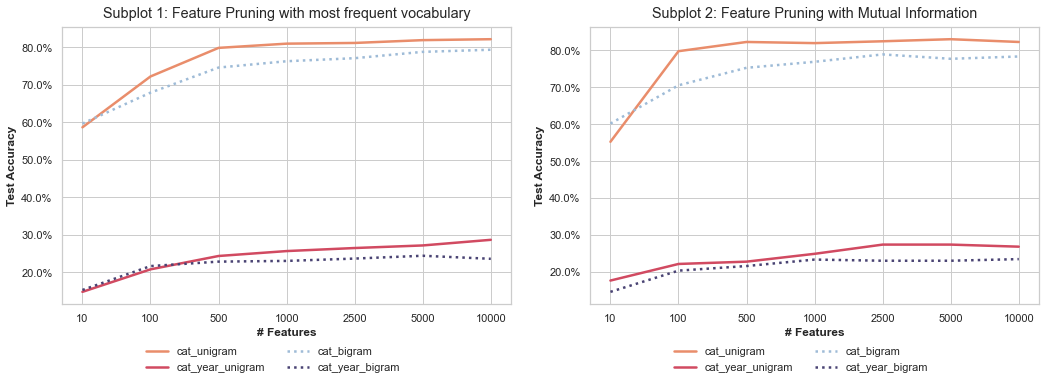

In [324]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 2, figsize=(15,6))
    
    #define meta params 
    prune_names = ["most frequent vocabulary","Mutual Information"]
    n_features = [10,100,500,1000,2500,5000,10000]
    colors = ['#e98d6b', '#d14a61','#9ebbd7','#494373']
    l_style = ["solid","solid","dotted","dotted"]
    fontweight="bold"
    fontsize=12
    pad=1
    
    axes = axes.ravel()
    
    for idx, prune_method in enumerate(["most_freq","mutual_info"]):
        
        x= [i for i,_ in enumerate(n_features)]
        
        #generate plot
        for i, config in enumerate(viz_dict_fp[prune_method].keys()):
        
            y = viz_dict_fp[prune_method][config]
        
            axes[idx].plot(x,y,label=config,color=colors[i],linewidth=2.5,linestyle=l_style[i])
        
        #format plot 
        axes[idx].legend(loc="lower center", ncol=2,frameon=False,bbox_to_anchor=(0.47, -0.28))
        xlabels = [""]+[f"{n_features[int(i)]}" for i in axes[idx].get_xticks()[1:-1]]+[""]
        axes[idx].set_xticklabels(xlabels)
        ylabels = [f"{x:.1%}" for x in axes[idx].get_yticks()]
        axes[idx].set_yticklabels(ylabels)
        axes[idx].set_ylabel("Test Accuracy",fontweight="bold",fontsize=fontsize)
        axes[idx].set_xlabel("# Features",fontweight="bold",fontsize=fontsize)
        axes[idx].set_title(f"Subplot {idx+1}: Feature Pruning with {prune_names[idx]}",fontweight="normal",fontsize=fontsize*1.2,y=pad*1.01 )   
    
    fig.tight_layout(pad=2.0)
    #plt.savefig("Visuals/Fig_13.png")
    plt.show()

### Ranking of all 56 Model candidates based on Accuracy (in-text)

In [254]:
#create empty results df 
results_df_fp = pd.DataFrame(columns=["model","test_accuracy"])

#convert results dict into df containing model config and associated test accuracy 
for idx,key in enumerate(results_dict_fp.keys()):
    results_df_fp.loc[idx,:] = [key,round(results_dict_fp[key]['Test_Acc'],4)]

#sort df in descending order 
results_df_fp.sort_values("test_accuracy",ascending=False)

,model,test_accuracy
38,mutual_info-unigram-cat-5000,0.8306
36,mutual_info-unigram-cat-2500,0.825
40,mutual_info-unigram-cat-10000,0.8231
32,mutual_info-unigram-cat-500,0.8231
12,most_freq-unigram-cat-10000,0.8213
34,mutual_info-unigram-cat-1000,0.82
10,most_freq-unigram-cat-5000,0.8188
8,most_freq-unigram-cat-2500,0.8112
6,most_freq-unigram-cat-1000,0.8094
4,most_freq-unigram-cat-500,0.7981


## Experiment 2 - Expanding Window Classification (1st Gating Experiment)

In [266]:
#instantiate object to capture model results 
results_dict_g1 = defaultdict(dict)

#instantiate object capturing output in visualiztion-friendly format
viz_dict_g1 = {}
viz_dict_g1["most_freq"] = defaultdict(list)
viz_dict_g1["mutual_info"] = defaultdict(list)
   
for data in [train, dev, test]:
    
    # CLEAN - remove stopwords from cleaned abstracts (tokenized,no punctuation, no blank spaces)
    data["abstract_clean"] = data.abstract_clean.apply(lambda x: rem_stopwords(x))

# CLEAN - only retain abstracts of length >= 5 (dev & test sets are fine)
train = train.loc[[True if len(a) > 5 else False for a in train.abstract_clean]]

# Note: Mutual Info Pruning is of interest only; results on most frequent words pruning captured in passing 
for prune_tech in ["most_freq","mutual_info"]:

#>>>>>>>> HYPERPARAM 1 - UNIGRAM vs. BIGRAM <<<<<<<<<<

    for gram_label, gram in zip(["unigram","bigram"],[1,2]):
        
        #>>>>>>>> HYPERPARAM 2 - Gate (% of text considered) <<<<<<<<<<
    
        for perc in [0.1,0.25,0.5,0.75,1]:
        
            for data in [train, dev, test]:
                
                data["abstract_clean_ngram"] = data.abstract_clean.apply(lambda x: abstract_clean2n_gram (x, grams=gram))
                data["abstract_clean_ngram"] = data.abstract_clean_ngram.apply(lambda x: shorten_abstract (x, perc=perc))
                
                
            #PREPARE - construct look-up dictionaries from cleaned abstracts (sored by most freq. occuring words)

            if prune_tech == "most_freq":
            
                w2id,id2w,_ = count_words(train.abstract_clean_ngram,remove_stopwords=True)
                
            if prune_tech == "mutual_info":
            
                w2id,id2w,_ = get_mi_per_label_lookup (train,label2id,"stat.ML","cs.AI",gram=gram)
                
                # PREPARE - only retain tokens in training dataset sequences that are in mi_vocab
                mi_vocab = dict.fromkeys(w2id, 0)
                train["abstract_clean_ngram"] = train["abstract_clean_ngram"].map(lambda x:oov_rem (x,mi_vocab))
            
            for size in [5000]:
            
                # retrieve amount of features to consider
                top_k_features = sorted(id2w)[:size]
                
                #ENCODE-1 - convert cleaned abstracts into integer representations based on look-up dict
                for data in [train, dev, test]: 
                    
                    data["abstract_enc"] = data.abstract_clean_ngram.apply(lambda x: encode_abstract(x, w2id))
                    
                    #Run time saving function - reduce abstract sequences only to tokens that are among the k features to speed up lookup 
                    data["abstract_enc"] = data.abstract_enc.apply(lambda x: abstract_enc_redux(x,size))
                    
                    #ENCODE-2 - convert each abstract into sparse vector representation based on look-up dict
                    data['sparse'] = data.abstract_enc.map(lambda x: sent2sparse(x,top_k_features))
                             
                ########### MODELING ########### 
                
                # Define device
                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                
                # (>>>>>>>> HYPERPARAM 3 - 2 vs. 8 class classification problem <<<<<<<<<<)
                
                for label_dict,label in zip([label2id,label2id_year],["cat","cat_year"]):
                #for label_dict,label in zip([label2id,label2id_year],["cat","cat_year"]):
                    
                    start = time.time()
                    
                    print("\033[1m" + f"Running model config: {gram_label}, {perc*100}% of text, {prune_tech} pruning, {len(train[label].unique())} labels, {size} features..." +"\033[0m")
                        
                    # Transform all data to torch tensors
                    train_x = torch.tensor(list(train["sparse"])).float()
                    train_y = torch.tensor([label_dict[p] for p in train[label]])
                    dev_x = torch.tensor(list(dev["sparse"])).float()
                    dev_y = torch.tensor([label_dict[p] for p in dev[label]])
                    test_x = torch.tensor(list(test["sparse"])).float()
                    test_y = torch.tensor([label_dict[p] for p in test[label]])
                    
                    # Configure model
                    input_dim = size
                    output_dim = len(train[label].unique())
                    
                    # Train and evaluate model
                    
                    classifier = LRClassifier(input_dim, output_dim)
                    acc_test,val_accs,true_lr, pred_lr = train_classifier(classifier, train_x, train_y, dev_x, dev_y, test_x, test_y, device)
                     
                    viz_dict_g1[prune_tech][f"{label}_{gram_label}"].append(acc_test)
                    
                    results_dict_g1[f"{prune_tech}-{gram_label}-{label}-{perc*100}%"]["Test_Acc"] = acc_test
                    results_dict_g1[f"{prune_tech}-{gram_label}-{label}-{perc*100}%"]["Top20_Predictors"] = [[id2w[i+2] for i in l] for l in classifier.linear.weight.topk(k=min(size,20), dim=-1)[1].tolist()]
                    results_dict_g1[f"{prune_tech}-{gram_label}-{label}-{perc*100}%"]["True_Labels"] = true_lr
                    results_dict_g1[f"{prune_tech}-{gram_label}-{label}-{perc*100}%"]["True_Labels"] = pred_lr
                    
                    end = time.time()
                    print(f"Execution Time ...{end - start}")
                

Running model config: unigram, 10.0% of text, most_freq pruning, 2 labels, 5000 features...
Accuracy on dev data after 05 epochs: 0.7244
Accuracy on dev data after 10 epochs: 0.7275
Accuracy on dev data after 15 epochs: 0.7262
Accuracy on dev data after 20 epochs: 0.7244
Accuracy on test data: 0.7237
Execution Time ...4.639978885650635
Running model config: unigram, 10.0% of text, most_freq pruning, 8 labels, 5000 features...
Accuracy on dev data after 05 epochs: 0.2006
Accuracy on dev data after 10 epochs: 0.1931
Accuracy on dev data after 15 epochs: 0.1981
Accuracy on dev data after 20 epochs: 0.2000
Accuracy on test data: 0.2163
Execution Time ...4.651855707168579
Running model config: unigram, 25.0% of text, most_freq pruning, 2 labels, 5000 features...
Accuracy on dev data after 05 epochs: 0.7769
Accuracy on dev data after 10 epochs: 0.7794
Accuracy on dev data after 15 epochs: 0.7775
Accuracy on dev data after 20 epochs: 0.7750
Accuracy on test data: 0.7700
Execution Time ...4.62

### Experiment 2 Graph Visualization (Figure 14)

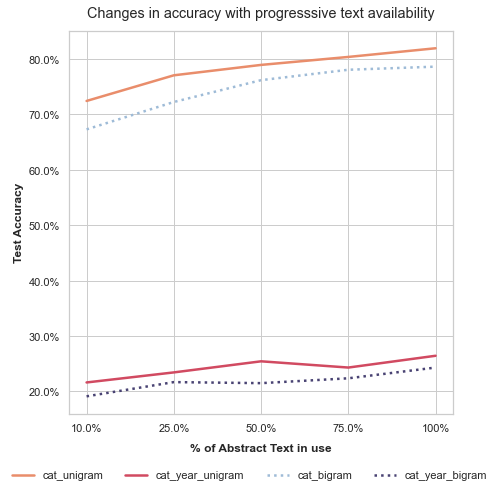

In [278]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(7,7))
    
    #define meta params 
    perc_text = [0.1,0.25,0.5,0.75,1]
    colors = ['#e98d6b', '#d14a61','#9ebbd7','#494373']
    l_style = ["solid","solid","dotted","dotted"]
    fontsize= 12
    fontweight = "bold"
    pad=1
    
    x= [i for i,_ in enumerate(perc_text)]
    
    for i, config in enumerate(viz_dict_g1["most_freq"].keys()):
        
        print()
        y = viz_dict_g1["most_freq"][config]
        
        #generate plot 
        ax.plot(x,y,label=config,color=colors[i],linewidth=2.5,linestyle=l_style[i])
    
    #format plot 
    ax.legend(loc="lower center", ncol=4,frameon=False,bbox_to_anchor=(0.47, -0.2))
    ax.set_xticks(np.arange(0, 5, 1.0))
    xlabels = [f"{perc_text[int(i)]*100}%" for i in ax.get_xticks()]
    ax.set_xticklabels(xlabels)
    ylabels = [f"{x:.1%}" for x in ax.get_yticks()]
    ax.set_yticklabels(ylabels)
    ax.set_ylabel("Test Accuracy",fontweight="bold",fontsize=fontsize)
    ax.set_xlabel("% of Abstract Text in use",fontweight=fontweight,fontsize=fontsize,labelpad=10)
    ax.set_title("\n".join(wrap("Changes in accuracy with progresssive text availability",60)),fontweight="normal",fontsize=fontsize*1.2,y=1.02)
    
    plt.tight_layout()  
    #plt.savefig("Visuals/Fig_14.png")
    plt.show()

### Ranking of all 20 Model candidates based on Accuracy (in-text)

In [268]:
#instantiate empty results df 
results_df_g1 = pd.DataFrame(columns=["model","test_accuracy"])

for idx,key in enumerate(results_dict_g1.keys()):
    
    #only retrive models grounding on MI feature based selection
    if "mutual_info" in key:
     
        results_df_g1.loc[idx,:] = [key,round(results_dict_g1[key]['Test_Acc'],4)]

#sort results in descening order 
results_df_g1.sort_values("test_accuracy",ascending=False)

,model,test_accuracy
28,mutual_info-unigram-cat-100%,0.8306
26,mutual_info-unigram-cat-75.0%,0.8163
24,mutual_info-unigram-cat-50.0%,0.7969
38,mutual_info-bigram-cat-100%,0.7788
36,mutual_info-bigram-cat-75.0%,0.7725
22,mutual_info-unigram-cat-25.0%,0.7706
34,mutual_info-bigram-cat-50.0%,0.7606
32,mutual_info-bigram-cat-25.0%,0.7375
20,mutual_info-unigram-cat-10.0%,0.7331
30,mutual_info-bigram-cat-10.0%,0.6781


## Experiment 3 - Sliding Window Classification (2nd Gating Experiment)

In [292]:
#instantiate object to capture model results 
results_dict_g2 = defaultdict(dict)

#instantiate object capturing output in visualiztion-friendly format
viz_dict_g2 = {}
viz_dict_g2["most_freq"] = defaultdict(list)
viz_dict_g2["mutual_info"] = defaultdict(list)
   
for data in [train, dev, test]:
    
    # CLEAN - remove stopwords from cleaned abstracts (tokenized,no punctuation, no blank spaces)
    data["abstract_clean"] = data.abstract_clean.apply(lambda x: rem_stopwords(x))

# CLEAN - only retain abstracts of length >= 5 (dev & test sets are fine)
train = train.loc[[True if len(a) > 5 else False for a in train.abstract_clean]]

# Note: Mutual Info Pruning is of interest only; results on most frequent words pruning captured in passing 
for prune_tech in ["most_freq","mutual_info"]:

#>>>>>>>> HYPERPARAM 1 - UNIGRAM vs. BIGRAM <<<<<<<<<<

    for gram_label, gram in zip(["unigram","bigram"],[1,2]):
        
        #>>>>>>>> HYPERPARAM 2 - Gate (Sliding 20% Windows) <<<<<<<<<<
    
        for window in [0,1,2,3,4]:
        
            for data in [train, dev, test]:
                
                data["abstract_clean_ngram"] = data.abstract_clean.apply(lambda x: abstract_clean2n_gram (x, grams=gram))
                data["abstract_clean_ngram"] = data["abstract_clean_ngram"].map(lambda x: partition_abstract (x, perc = 0.2, section=window))
                
            #PREPARE - construct look-up dictionaries from cleaned abstracts (sored by most freq. occuring words)
            
            if prune_tech == "most_freq":
            
                w2id,id2w,_ = count_words(train.abstract_clean_ngram,remove_stopwords=True)
            
            
            if prune_tech == "mutual_info":
            
                w2id,id2w,_ = get_mi_per_label_lookup (train,label2id,"stat.ML","cs.AI",gram=gram)
                
                # PREPARE - only retain tokens in training dataset sequences that are in mi_vocab
                mi_vocab = dict.fromkeys(w2id, 0)
                train["abstract_clean_ngram"] = train["abstract_clean_ngram"].map(lambda x:oov_rem (x,mi_vocab))
            
            for size in [5000]:
            
                # retrieve amount of features to consider
                top_k_features = sorted(id2w)[:size]
                
                #ENCODE-1 - convert cleaned abstracts into integer representations based on look-up dict
                for data in [train, dev, test]: 
                    
                    data["abstract_enc"] = data.abstract_clean_ngram.apply(lambda x: encode_abstract(x, w2id))
                    #Run time saving function - reduce abstract sequences only to tokens that are among the k features to speed up lookup 
                    data["abstract_enc"] = data.abstract_enc.apply(lambda x: abstract_enc_redux(x,size))
                    
                    #ENCODE-2 - convert each abstract into sparse vector representation based on look-up dict
                    data['sparse'] = data.abstract_enc.map(lambda x: sent2sparse(x,top_k_features))
                             
                ########### MODELING ########### 
                
                # Define device
                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                
                # (>>>>>>>> HYPERPARAM 3 - 2 vs. 8 class classification problem <<<<<<<<<<)
                
                for label_dict,label in zip([label2id,label2id_year],["cat","cat_year"]):
        
                    
                    start = time.time()
                    
                    print("\033[1m" + f"Running model config: {gram_label}, Window {window+1} of text, {prune_tech} pruning, {len(train[label].unique())} labels, {size} features..." +"\033[0m")
                        
                    # Transform all data to torch tensors
                    train_x = torch.tensor(list(train["sparse"])).float()
                    train_y = torch.tensor([label_dict[p] for p in train[label]])
                    dev_x = torch.tensor(list(dev["sparse"])).float()
                    dev_y = torch.tensor([label_dict[p] for p in dev[label]])
                    test_x = torch.tensor(list(test["sparse"])).float()
                    test_y = torch.tensor([label_dict[p] for p in test[label]])
                    
                    # Configure model
                    input_dim = size
                    output_dim = len(train[label].unique())
                    
                    # Train and evaluate model
                    
                    classifier = LRClassifier(input_dim, output_dim)
                    acc_test,val_accs,true_lr, pred_lr = train_classifier(classifier, train_x, train_y, dev_x, dev_y, test_x, test_y, device)
                          
                    #Capture Results
                     
                    viz_dict_g2[prune_tech][f"{label}_{gram_label}"].append(acc_test)
                    
                    results_dict_g2[f"{prune_tech}-{gram_label}-{label}-{window+1}"]["Test_Acc"] = acc_test
                    results_dict_g2[f"{prune_tech}-{gram_label}-{label}-{window+1}"]["Top20_Predictors"] = [[id2w[i+2] for i in l] for l in classifier.linear.weight.topk(k=min(size,20), dim=-1)[1].tolist()]
                    results_dict_g2[f"{prune_tech}-{gram_label}-{label}-{window+1}"]["True_Labels"] = true_lr
                    results_dict_g2[f"{prune_tech}-{gram_label}-{label}-{window+1}"]["True_Labels"] = pred_lr
                    
                    end = time.time()
                    print(f"Execution Time ...{end - start}")
                

Running model config: unigram, Window 1 of text, most_freq pruning, 2 labels, 5000 features...
Accuracy on dev data after 05 epochs: 0.7631
Accuracy on dev data after 10 epochs: 0.7719
Accuracy on dev data after 15 epochs: 0.7719
Accuracy on dev data after 20 epochs: 0.7731
Accuracy on test data: 0.7600
Execution Time ...6.091121196746826
Running model config: unigram, Window 1 of text, most_freq pruning, 8 labels, 5000 features...
Accuracy on dev data after 05 epochs: 0.2069
Accuracy on dev data after 10 epochs: 0.2194
Accuracy on dev data after 15 epochs: 0.2138
Accuracy on dev data after 20 epochs: 0.2050
Accuracy on test data: 0.2231
Execution Time ...6.519791841506958
Running model config: unigram, Window 2 of text, most_freq pruning, 2 labels, 5000 features...
Accuracy on dev data after 05 epochs: 0.7588
Accuracy on dev data after 10 epochs: 0.7600
Accuracy on dev data after 15 epochs: 0.7681
Accuracy on dev data after 20 epochs: 0.7688
Accuracy on test data: 0.7525
Execution Tim

### Experiment 3 Graph Visualization (Figure 15)

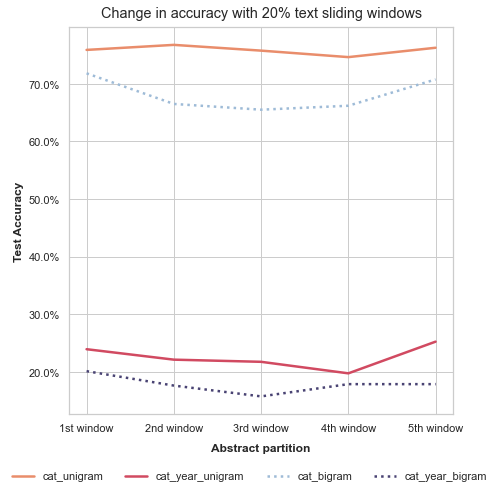

In [299]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(7,7))
    
    #define meta params 
    windows = [0,1,2,3,4]
    w_labels = ["1st","2nd","3rd","4th","5th"]
    colors = ['#e98d6b', '#d14a61','#9ebbd7','#494373']
    l_style = ["solid","solid","dotted","dotted"]
    fontsize= 12
    fontweight = "bold"
    pad=1
    
    x= [i for i,_ in enumerate(windows)]
    
    for i, config in enumerate(viz_dict_g2["mutual_info"].keys()):
        
        y = viz_dict_g2["mutual_info"][config]
    
        #generate plot 
        ax.plot(x,y,label=config,color=colors[i],linewidth=2.5,linestyle=l_style[i])
    
    #format plot 
    ax.legend(loc="lower center", ncol=4,frameon=False,bbox_to_anchor=(0.47, -0.2))
    ylabels = [f"{x:.1%}" for x in ax.get_yticks()]
    ax.set_yticklabels(ylabels)
    ax.set_xticks(np.arange(0, 5, 1.0))
    xlabels = [f"{w_labels[int(i)]} window" for i in ax.get_xticks()]
    ax.set_xticklabels(xlabels)
    ax.set_ylabel("Test Accuracy",fontweight="bold",fontsize=fontsize)
    ax.set_xlabel("Abstract partition",fontweight="bold",fontsize=fontsize,labelpad=10)
    ax.set_title("\n".join(wrap("Change in accuracy with 20% text sliding windows",60)),fontweight="normal",fontsize=fontsize*1.2,y=pad*1.01)
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
    
    plt.tight_layout() 
    #plt.savefig("Visuals/Fig_15.png")
    plt.show()

### Ranking of all 20 Model candidates based on Accuracy (in-text)

In [300]:
#instantiate empty results df 
results_df_g2 = pd.DataFrame(columns=["model","test_accuracy"])

for idx,key in enumerate(results_dict_g2.keys()):
    
    #only retrive models grounding on MI feature based selection
    if "mutual_info" in key:
     
        results_df_g2.loc[idx,:] = [key,round(results_dict_g2[key]['Test_Acc'],4)]

#sort results in descening order 
results_df_g2.sort_values("test_accuracy",ascending=False)

,model,test_accuracy
22,mutual_info-unigram-cat-2,0.7675
28,mutual_info-unigram-cat-5,0.7625
20,mutual_info-unigram-cat-1,0.7588
24,mutual_info-unigram-cat-3,0.7575
26,mutual_info-unigram-cat-4,0.7462
30,mutual_info-bigram-cat-1,0.7181
38,mutual_info-bigram-cat-5,0.7075
32,mutual_info-bigram-cat-2,0.665
36,mutual_info-bigram-cat-4,0.6619
34,mutual_info-bigram-cat-3,0.655


# Spot Checks

**PLEASE NOTE: The below analyses were performed in response to findings and were not part of originally conceived research methodology**

## Spot Check 1 - FFNN Classifier 

In [55]:
# Define feed-forward neural network classifier class
class FNNClassifier(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_dim):
        
        super(FNNClassifier, self).__init__()
        self.linear_1 = nn.Linear(input_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h = torch.tanh(self.linear_1(x))
        return self.linear_2(h)

In [905]:
#instantiate object to capture model results 
results_dict_nn = defaultdict(dict)

#instantiate object capturing output in visualiztion-friendly format
viz_dict_nn = {}
viz_dict_nn["most_freq"] = defaultdict(list)
viz_dict_nn["mutual_info"] = defaultdict(list)
   
for data in [train, dev, test]:
    
    # CLEAN - remove stopwords from cleaned abstracts (tokenized,no punctuation, no blank spaces)
    data["abstract_clean"] = data.abstract_clean.apply(lambda x: rem_stopwords(x))

# CLEAN - only retain abstracts of length >= 5 (dev & test sets are fine)
train = train.loc[[True if len(a) >=5 else False for a in train.abstract_clean]]

# Note: Mutual Info Pruning is of interest only; results on most frequent words pruning captured in passing 
for prune_tech in ["most_freq","mutual_info"]:

#>>>>>>>> HYPERPARAM 1 - UNIGRAM vs. BIGRAM <<<<<<<<<<

    for gram_label, gram in zip(["unigram","bigram"],[1,2]):
    
        for data in [train, dev, test]:
                                    
            data["abstract_clean_ngram"] = data.abstract_clean.apply(lambda x: abstract_clean2n_gram (x, grams=gram))
            #data["abstract_clean_ngram"] = data.abstract_clean_ngram.apply(lambda x: shorten_abstract (x, perc=1))
            
        #PREPARE - construct look-up dictionaries from cleaned abstracts (sored by most freq. occuring words)
        
        if prune_tech == "most_freq":
        
            w2id,id2w,_ = count_words(train.abstract_clean_ngram,remove_stopwords=True)

        if prune_tech == "mutual_info":
        
            w2id,id2w,_ = get_mi_per_label_lookup (train,label2id,"stat.ML","cs.AI",gram=gram)
            
            # PREPARE - only retain tokens in training dataset sequences that are in mi_vocab
            mi_vocab = dict.fromkeys(w2id, 0)
            train["abstract_clean_ngram"] = train["abstract_clean_ngram"].map(lambda x:oov_rem (x,mi_vocab))
        
        for size in [10000]:
        
            # retrieve amount of features to consider
            top_k_features = sorted(id2w)[:size]
            
            #ENCODE-1 - convert cleaned abstracts into integer representations based on look-up dict
            for data in [train, dev, test]: 
                
                data["abstract_enc"] = data.abstract_clean_ngram.apply(lambda x: encode_abstract(x, w2id))
                #Run time saving function - reduce abstract sequences only to tokens that are among the k features to speed up lookup 
                data["abstract_enc"] = data.abstract_enc.apply(lambda x: abstract_enc_redux(x,size))
                
                #ENCODE-2 - convert each abstract into sparse vector representation based on look-up dict
                data['sparse'] = data.abstract_enc.map(lambda x: sent2sparse(x,top_k_features))
                         
            ########### MODELING ########### 
            
            # Define device
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            
            #>>>>>>>> HYPERPARAM 4 - 2 vs. 8 class classification problem <<<<<<<<<<
            
            for label_dict,label in zip([label2id,label2id_year],["cat","cat_year"]):
        
                
                start = time.time()
                    
                # Transform all data to torch tensors
                train_x = torch.tensor(list(train["sparse"])).float()
                train_y = torch.tensor([label_dict[p] for p in train[label]])
                dev_x = torch.tensor(list(dev["sparse"])).float()
                dev_y = torch.tensor([label_dict[p] for p in dev[label]])
                test_x = torch.tensor(list(test["sparse"])).float()
                test_y = torch.tensor([label_dict[p] for p in test[label]])
                
                # Configure Model
                input_dim = size
                output_dim = len(train[label].unique())
                
                # Train and evaluate model
                
                #>>>>>>>> HYPERPARAM 2 - different hidden layer sizes <<<<<<<<<
                
                for d in [5, 10, 50, 100, 500]:
                    
                    print("\033[1m" + f"Running model config: {prune_tech} pruning, {gram_label}, {d} hidden layer, {len(train[label].unique())} labels, {size} features..." +"\033[0m")
                
                    classifier = FNNClassifier(input_dim, output_dim,d)
                    acc_test,val_accs,true_lr, pred_lr = train_classifier(classifier, train_x, train_y, dev_x, dev_y, test_x, test_y, device)
                            
                    #Store Results 
                
                    viz_dict_nn[prune_tech][f"{label}_{gram_label}"].append(acc_test)
                    
                    results_dict_nn[f"{prune_tech}-{gram_label}-{label}-{d}"]["Test_Acc"] = acc_test
                    results_dict_nn[f"{prune_tech}-{gram_label}-{label}-{d}"]["True_Labels"] = true_lr
                    results_dict_nn[f"{prune_tech}-{gram_label}-{label}-{d}"]["Pred_Labels"] = pred_lr
                    
                    end = time.time()
                    print(f"Execution Time ...{end - start}")
            

Running model config: unigram, 5 hidden layer, 2 labels, 10000 features...
Accuracy on dev data after 05 epochs: 0.8119
Accuracy on dev data after 10 epochs: 0.8356
Accuracy on dev data after 15 epochs: 0.8381
Accuracy on dev data after 20 epochs: 0.8294
Accuracy on test data: 0.8306
Execution Time ...10.021800994873047
Running model config: unigram, 10 hidden layer, 2 labels, 10000 features...
Accuracy on dev data after 05 epochs: 0.8281
Accuracy on dev data after 10 epochs: 0.8375
Accuracy on dev data after 15 epochs: 0.8275
Accuracy on dev data after 20 epochs: 0.8138
Accuracy on test data: 0.8150
Execution Time ...13.454941034317017
Running model config: unigram, 50 hidden layer, 2 labels, 10000 features...
Accuracy on dev data after 05 epochs: 0.8281
Accuracy on dev data after 10 epochs: 0.8369
Accuracy on dev data after 15 epochs: 0.8300
Accuracy on dev data after 20 epochs: 0.8062
Accuracy on test data: 0.8131
Execution Time ...21.174937963485718
Running model config: unigram, 1

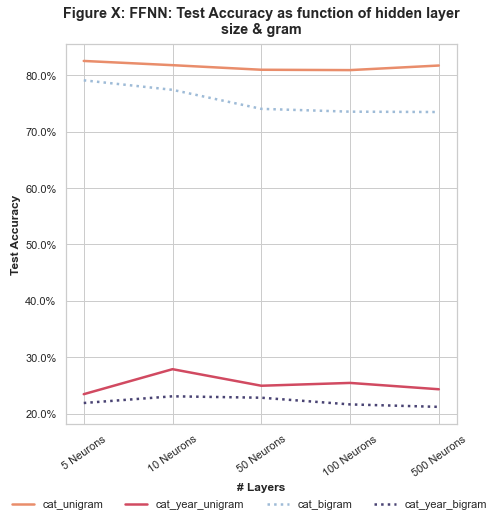

In [910]:
with sns.axes_style("whitegrid"):

    fig, ax = plt.subplots(figsize=(7,7))
    
    d = [5, 10, 50, 100, 500]
    colors = ['#e98d6b', '#d14a61','#9ebbd7','#494373']
    l_style = ["solid","solid","dotted","dotted"]
    
    fontsize= 12
    fontweight = "bold"
    pad=1
    
    x= [i for i,_ in enumerate(d)]
    
    for i, config in enumerate(viz_dict_nn["mutual_info"].keys()):
        
        print()
        y = viz_dict_nn["mutual_info"][config]
    
        ax.plot(x,y,label=config,color=colors[i],linewidth=2.5,linestyle=l_style[i])
        
    ax.legend(loc="lower center", ncol=4,frameon=False,bbox_to_anchor=(0.47, -0.25))
    ax.set_xticks(np.arange(min(x), max(x)+1, 1.0))
    
    xlabels = [f"{d[int(i)]} Neurons" for i in ax.get_xticks()]
    ax.set_xticklabels(xlabels)
    ylabels = [f"{x:.1%}" for x in ax.get_yticks()]
    ax.set_yticklabels(ylabels)
    
    ax.set_ylabel("Test Accuracy",fontweight="bold",fontsize=fontsize)
    ax.set_xlabel("# Layers",fontweight="bold",fontsize=fontsize)
    ax.set_title("\n".join(wrap("Figure X: FFNN: Test Accuracy as function of hidden layer size & gram",60)),fontweight=fontweight,fontsize=fontsize*1.2,y=pad*1.01)
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(35)
    
    plt.show()

## Spot Check 2 - LSTM Classifier 

In [95]:
def oov_rem (abstract,emb):
    """Remove words from abstracts for which no ft embedding is available 
    (Only needed if subword reconstruction by ft is not used)"""
    return [w for w in abstract if w in emb]

def fasttext_emb_dict(word_freq_dict, emb, approx_oov=False):
    """Create dictionnary with fasttext embeddings for abstract word space 
    
    Parameters: 
    
    arg1 (Counter): Counter dict containing word freq counts for all words irrespective of class membership
    arg2 (bin): fasttext word vector collection in raw format 
    arg3 (Bool): Whether or not approximiations will for oov words will be provisioned by fasttext (default )
    
    returns:
    
    embedding dict 
    oov dict
    
    """
    
    if approx_oov == True:
        
        return {word: emb.get_word_vector(word) for word, _ in word_freq_dict.most_common()}
    
    if approx_oov == False:
        
        oov_dict = Counter({word:count for word, count in word_freq_dict.most_common() if emb.get_word_id(word) == -1})
        
        print(f"most freq 10 OOV words: {oov_dict.most_common(10)}")
        print(f"# of unique OOV words: {len(oov_dict.keys())} / {round((len(oov_dict.keys())/ len(word_freq_dict.keys())),2)*100}%")
        print(f"# OOV word frequencies: {sum(oov_dict.values())} / {round((sum(oov_dict.values())/ sum(word_freq_dict.values())),2)*100}%")
        
        return {word: emb.get_word_vector(word) for word, _ in word_freq_dict.most_common() if emb.get_word_id(word) != -1}, oov_dict    

In [96]:
# Define dataset class
class LSTMDataset(Dataset):

    def __init__(self, data, w2id):
        
        # Encode abstracts
        self.abstracts = list(data.abstract_clean.apply(lambda x: [w2id[w] if w in w2id else 1 for w in x]))
        
        # Store labels
        self.labels = list(data.cat_year_label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        abstract = self.abstracts[idx]
        label = self.labels[idx]
        return abstract, label

In [97]:
# Define collate function
def lstm_collate(batch):
    
    # Store batch size
    batch_size = len(batch)

    # Separate abstracts and labels
    abstracts = [a for a, _ in batch]
    labels = torch.tensor([l for _, l in batch]).long()

    # Store length of longest abstract in batch
    max_len = max(len(a) for a in abstracts)

    # Create padded abstract tensors
    abstracts_pad = torch.zeros((batch_size, max_len)).long()
    for i, a in enumerate(abstracts):
        abstracts_pad[i, :len(a)] = torch.tensor(a)

    return abstracts_pad, labels

In [98]:
# Define LSTM classifier
class LSTMClassifier(nn.Module):
    
    def __init__(self, pretrained_emb, hidden_dim, output_dim):
        
        # Define network layers
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_emb, padding_idx=0)
        self.lstm = nn.LSTM(pretrained_emb.shape[1], hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        
        # Define dropout
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, abstracts):
            
        # Define flow of tensors through network
        emb = self.embedding(abstracts)
        output, (hidden, cell) = self.lstm(self.dropout(emb))
        return self.linear(self.dropout(output[:, -1, :]))

### LSTM Model training without OOV fasttext approximiations

In [946]:
# Create dictionary for word look-up
word_counter = Counter([w for a in train.abstract_clean for w in a])
w2id = {w: i + 2 for i, w in enumerate(w for w, c in word_counter.most_common())}

# Create dictionary for reverse word look-up
id2w = {i: w for w, i in w2id.items()}

In [925]:
#Retrive fasstext vectors 
ft = fasttext.load_model('Data/cc.en.300.bin')  

In [ ]:
#retrive fasttext embeddings WITHOUT reconstructed embeddings based on subwords for OOV vocabulary 
fasttext_dict,_ = fasttext_emb_dict(word_counter, ft, approx_oov=False)

In [971]:
emb_set = dict.fromkeys(fasttext_dict, 0)

#remove words from abstracts that are not in fasttext vocab
train["abstract_clean"] = train.abstract_clean.map(lambda x:oov_rem (x,emb_set))

#update Look-up dicts after abstracts where stripped 
word_counter = Counter([w for a in train.abstract_clean for w in a])
w2id = {w: i + 2 for i, w in enumerate(w for w, c in word_counter.most_common())}

# Create dictionary for reverse word look-up
id2w = {i: w for w, i in w2id.items()}

In [973]:
# Create datasets
train_dataset = LSTMDataset(train, w2id)
dev_dataset = LSTMDataset(dev, w2id)
test_dataset = LSTMDataset(test, w2id)

In [974]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=100, collate_fn=lstm_collate, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=100, collate_fn=lstm_collate)
test_loader = DataLoader(test_dataset, batch_size=100, collate_fn=lstm_collate)

In [975]:
# Create matrix of pretrained embeddings
fasttext_emb = torch.tensor([fasttext_dict[id2w[i]] for i in range(2, len(id2w) + 2)]).float()
fasttext_emb = torch.cat((torch.zeros((1, 300)), fasttext_emb.mean(axis=0, keepdim=True), fasttext_emb), axis=0)
fasttext_emb.shape

torch.Size([30784, 300])

In [976]:
# Initialize model
model = LSTMClassifier(fasttext_emb, 200, 8)

In [977]:
# Define optimizer and training objective
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [978]:
# Define device and move model to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [979]:
# Train model
for e in range(1, 6):

    model.train()

    for i, b in enumerate(train_loader):
        
        if i % 20 == 0:
            print(f"Batch {i}...")
        
        # Perform forward pass
        optimizer.zero_grad()
        abstracts, lbls = [t.to(device) for t in b]
        output = model(abstracts)
        loss = criterion(output, lbls)
        
        # Perform backpropagation and update weights
        loss.backward()
        optimizer.step()

    # Evaluate model on development data
    model.eval()

    y_true = list()
    y_pred = list()

    with torch.no_grad():
        for b in dev_loader:
            abstracts, lbls = [t.to(device) for t in b]
            output = model(abstracts)
            max_output = output.argmax(dim=1)
            y_true.extend(lbls.tolist())
            y_pred.extend(max_output.tolist())
            
    print('Development accuracy after {} epoch(s): {:.2f}'.format(e, accuracy_score(y_true, y_pred)))

Batch 0...
Batch 20...
Batch 40...
Batch 60...
Batch 80...
Batch 100...
Batch 120...
Development accuracy after 1 epoch(s): 0.12
Batch 0...
Batch 20...
Batch 40...
Batch 60...
Batch 80...
Batch 100...
Batch 120...
Development accuracy after 2 epoch(s): 0.12
Batch 0...
Batch 20...
Batch 40...
Batch 60...
Batch 80...
Batch 100...
Batch 120...
Development accuracy after 3 epoch(s): 0.12
Batch 0...
Batch 20...
Batch 40...
Batch 60...
Batch 80...
Batch 100...
Batch 120...
Development accuracy after 4 epoch(s): 0.12
Batch 0...
Batch 20...
Batch 40...
Batch 60...
Batch 80...
Batch 100...
Batch 120...
Development accuracy after 5 epoch(s): 0.12


In [980]:
# Evaluate model on test data
model.eval()

y_true = list()
y_pred = list()

with torch.no_grad():
    for b in test_loader:
        abstracts, lbls = [t.to(device) for t in b]
        output = model(abstracts)
        max_output = output.argmax(dim=1)
        y_true.extend(lbls.tolist())
        y_pred.extend(max_output.tolist())

print('Test accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))

Test accuracy: 0.13


### LSTM Model training with OOV fasttext approximiations

In [991]:
# Create dictionary for word look-up
word_counter = Counter([w for a in train.abstract_clean for w in a])
w2id = {w: i + 2 for i, w in enumerate(w for w, c in word_counter.most_common())}

# Create dictionary for reverse word look-up
id2w = {i: w for w, i in w2id.items()}

##retrive fasttext embeddings WITH reconstructed embeddings based on subwords for OOV vocabulary 
fasttext_dict_oov = fasttext_emb_dict(word_counter, ft, approx_oov=True)

# Create matrix of pretrained embeddings
fasttext_emb = torch.tensor([fasttext_dict_oov[id2w[i]] for i in range(2, len(id2w) + 2)]).float()
fasttext_emb = torch.cat((torch.zeros((1, 300)), fasttext_emb.mean(axis=0, keepdim=True), fasttext_emb), axis=0)
print(fasttext_emb.shape)

# Initialize model
model = LSTMClassifier(fasttext_emb, 200, 8)

torch.Size([51743, 300])


In [992]:
# Train model
for e in range(1, 6):

    model.train()

    for i, b in enumerate(train_loader):
        
        if i % 20 == 0:
            print(f"Batch {i}...")
        
        # Perform forward pass
        optimizer.zero_grad()
        abstracts, lbls = [t.to(device) for t in b]
        output = model(abstracts)
        loss = criterion(output, lbls)
        
        # Perform backpropagation and update weights
        loss.backward()
        optimizer.step()

    # Evaluate model on development data
    model.eval()

    y_true = list()
    y_pred = list()

    with torch.no_grad():
        for b in dev_loader:
            abstracts, lbls = [t.to(device) for t in b]
            output = model(abstracts)
            max_output = output.argmax(dim=1)
            y_true.extend(lbls.tolist())
            y_pred.extend(max_output.tolist())
            
    print('Development accuracy after {} epoch(s): {:.2f}'.format(e, accuracy_score(y_true, y_pred)))

Batch 0...
Batch 20...
Batch 40...
Batch 60...
Batch 80...
Batch 100...
Batch 120...
Development accuracy after 1 epoch(s): 0.12
Batch 0...
Batch 20...
Batch 40...
Batch 60...
Batch 80...
Batch 100...
Batch 120...
Development accuracy after 2 epoch(s): 0.12
Batch 0...
Batch 20...
Batch 40...
Batch 60...
Batch 80...
Batch 100...
Batch 120...
Development accuracy after 3 epoch(s): 0.12
Batch 0...
Batch 20...
Batch 40...
Batch 60...
Batch 80...
Batch 100...
Batch 120...
Development accuracy after 4 epoch(s): 0.12
Batch 0...
Batch 20...
Batch 40...
Batch 60...
Batch 80...
Batch 100...
Batch 120...
Development accuracy after 5 epoch(s): 0.12


In [993]:
# Evaluate model on test data
model.eval()

y_true = list()
y_pred = list()

with torch.no_grad():
    for b in test_loader:
        abstracts, lbls = [t.to(device) for t in b]
        output = model(abstracts)
        max_output = output.argmax(dim=1)
        y_true.extend(lbls.tolist())
        y_pred.extend(max_output.tolist())

print('Test accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))

Test accuracy: 0.12
